In [2]:
import sys,os
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib.patheffects as pe
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import vaex
import astropy.units as u
from math import ceil
import reverse_indices_2d as ri
import astropy as aspy
from astroquery.ipac.irsa import Irsa
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import ascii
from astropy.io import fits
from scipy.optimize import curve_fit
from scipy import stats
from scipy.stats import gaussian_kde
from scipy.stats import norm
from scipy.interpolate import UnivariateSpline as spline
import cmasher as cm
import copy

In [3]:
run ../scripts/rc_params.py

rcParams updated :)


## The Catalogs

In [246]:
#Create a dataframe of PHATTER sources
#First cut to the data is GST criteria for the IR filters

phatter = vaex.open('/Users/tatianasandford/Documents/Research/M33/M33_full_matched.hdf5')

phatter = phatter[
        (phatter.F110W_SNR > 4) & (phatter.F110W_SHARP**2 < 0.15) & (phatter.F110W_CROWD < 2.25) & 
        (phatter.F160W_SNR > 4) & (phatter.F160W_SHARP**2 < 0.15) & 
        (phatter.F160W_CROWD < 2.25) & (phatter.F110W_VEGA == phatter.F110W_VEGA)
       ]

21980690

In [5]:
#Add index to PHATTER dataframe
phatter['INDEX'] = np.arange(len(phatter))
###Add 110-160 color column to dataframe for convenience
phatter['F110W_F160W'] = phatter['F110W_VEGA'] - phatter['F160W_VEGA']

In [6]:
# Set the aspect ratio for any ra/dec plot of M33

ra_max, ra_min = phatter.RA.max(), phatter.RA.min()
dec_max, dec_min = phatter.DEC.max(), phatter.DEC.min()
dec_m33 = phatter.DEC.mean()

m33_ar = (dec_max - dec_min) / ((ra_max - ra_min)*np.cos(np.pi/180.*dec_m33))

In [7]:
#Extract index, RA, and DEC  with GST cuts for easy plotting later
index_gst = phatter.INDEX.evaluate()
ra_gst, dec_gst = phatter.RA.evaluate(), phatter.DEC.evaluate()

In [8]:
print('Coordinate Span of PHATTER footprint')
print('RA (deg): {:.4f} - {:.4f}'.format(ra_min, ra_max))
print('DEC (deg): {:.4f} - {:.4f}'.format(dec_min, dec_max))

Coordinate Span of PHATTER footprint
RA (deg): 23.3422 - 23.6613
DEC (deg): 30.4894 - 30.8491


In [9]:
spitz_fits = fits.open('./spitzer_m33.fits')
spitz_fits.info()

Filename: ./spitzer_m33.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      62   ()      
  1  J_ApJS_219_42_psc    1 BinTableHDU    111   78841R x 20C   [D, D, E, E, E, E, E, E, A, E, E, E, A, E, E, E, A, E, E, 7A]   


In [10]:
names = ['ra', 'dec', 'mag36', 'e36', 'd36', 'mag45', 'e45', 'd45', 'blank1', 'mag58', 'e58', 'd58', 'blank2', 'mag80', 'e80', 'd80', 'blank3', 'mag24', 'e24', 'Gal']
spitz_all = aspy.table.Table(spitz_fits[1].data, names=names)
spitz_all.remove_columns(['blank1', 'blank2', 'blank3'])

In [11]:
spitz_all[:2]

ra,dec,mag36,e36,d36,mag45,e45,d45,mag58,e58,d58,mag80,e80,d80,mag24,e24,Gal
float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str7
23.40441,30.389219999999995,7.72,0.05,-0.69,7.75,0.03,-0.2,7.66,0.02,0.04,7.6,0.06,0.01,7.65,0.05,M33
23.662449999999996,30.844349999999995,7.86,0.03,-0.6,7.89,0.02,-0.15,7.74,0.01,0.02,7.65,0.11,0.01,7.69,0.01,M33


In [12]:
cut, = np.where((spitz_all['ra'] >= 23.342) & (spitz_all['ra'] <= 23.662) & (spitz_all['dec'] >= 30.489) & (spitz_all['dec'] <= 30.850))

In [13]:
spitz_ftprnt = spitz_all[cut]

## Data Reduction

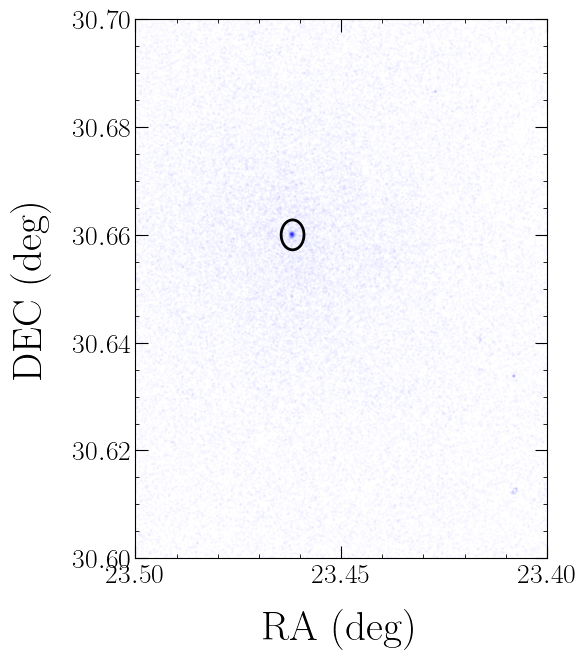

In [14]:
#Define a circle around the center of the galaxy where crowding has the most effect

fig, ax = plt.subplots(1)

plt.rcParams["axes.axisbelow"] = False



qc, = np.where(phatter.F160W_VEGA.evaluate() <= 20)
plot = ax.scatter(ra_gst[qc], dec_gst[qc],
                 #bins=300,
                 #cmap=cmap,
                 #vmax=20
                  c='blue', s=1, alpha=0.01
                );
center_ra, center_dec = 23.4618, 30.66
ctr = patches.Circle((center_ra, center_dec), radius=10/3600, edgecolor='black', facecolor=(0,0,0,0), linewidth=2)
ax.add_patch(ctr)

#zoom in on center
ax.set_xlim(23.4,23.5)
ax.set_ylim(30.6,30.7)

ax.set_xlabel('RA (deg)')
ax.set_ylabel('DEC (deg)')
ax.set_aspect(m33_ar)
ax.invert_xaxis()

#plt.savefig('./images/ctr_cutout.png', bbox_inches='tight')

In [15]:
#remove the spitzer sources within the central circle
ctr_path = ctr.get_path()
ctr_transform = ctr.get_patch_transform()
c_path = ctr_transform.transform_path(ctr_path)

spitz_pts = np.stack((spitz_ftprnt['ra'], spitz_ftprnt['dec']), axis=1)
no_ctr, = np.where(~c_path.contains_points(spitz_pts))

spitzer = spitz_ftprnt[no_ctr]

In [16]:
#Add an index to more easily reference specific sources
spitzer['index'] = np.arange(0, len(spitzer), 1)

In [17]:
#Spitzer 3.6 band flux convertsion from Reach et al, 2005
#Absolute Calibration of the Infrared Array...
#Gives the conversion to magnitude as m = 2.5log10(F_0/F_d)
#where F_d is the measured flux density and F_0 is the zero point
#flux density - 280.9 +/- 4.1 for the 3.6 band

#F_d = 280.9(+-4.1)*10**(m/2.5)

def spitzer_mag_to_fd(mag):
    #gives flux density
    fd = 280.9 * 10**(-mag / 2.5)
    return fd

# Color Conversion

In [18]:
#import the SAGE catalog - cut at 4 < 3.6mag < 11 and
#matched to gaia using their database xmatch capability
sage = vaex.open('./xmatch_sage_gaia.csv')

In [19]:
sage.head(2)

#,separation,sage_oid,c,sstisagema,raj2000,dej2000,jmag,e_jmag,q_jmag,hmag,e_hmag,q_hmag,col__3_6_,e__3_6_,q__3_6_,col__4_5_,e__4_5_,q__4_5_,col__5_8_,e__5_8_,q__5_8_,col__8_0_,e__8_0_,q__8_0_,snj,snh,sn3_6,sn4_5,sn5_8,sn8_0,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot
<i style='opacity: 0.6'>0</i>,0.000114445,1,1,J022608.23-753512.3,36.5343,-75.5868,11.241,0.024,2.93601e+07,10.952,0.024,2.93601e+07,10.82,0.04,16384,10.864,0.034,16384,10.789,0.036,0,10.603,0.108,512,45.24,45.24,27.22,32.18,30.27,10.06,1.63615e+18,Gaia DR3 4634185256147360384,4.63419e+18,7.89517e+08,2016,36.5348,0.0108566,-75.5867,0.0101583,1.84783,0.0118416,156.045,40.0127,33.8554,0.0120819,21.3266,0.0128596,0.00107817,0.419889,-0.0801707,-0.113675,0.0392334,-0.0279451,0.0107593,0.0990436,-0.220063,-0.0911263,347,347,345,2,3.81854,749.762,0.0839638,10.3538,31,True,1.5553,nan,nan,nan,nan,nan,nan,nan,40,26,0.0183404,46,17,0,0.0253767,68.059,0,0,1.14893,nan,nan,nan,nan,nan,nan,nan,nan,False,390,239913,47.4212,5059.18,12.2372,44,129190,62.6142,2063.27,12.5605,44,158518,56.2719,2817,11.7477,1.19922,0,1,0,0,0,0.81277,0.323236,0.489533,5.78594,0.713328,1,22,2,19,30.8924,-0.143329,0.375279,974.724,12.2899,5750,4,0.25,222,13.1103,10.4294,15,11.5786,0.0155482,20,31.1725,NOT_AVAILABLE,295.42,-40.1295,308.738,-71.3604,False

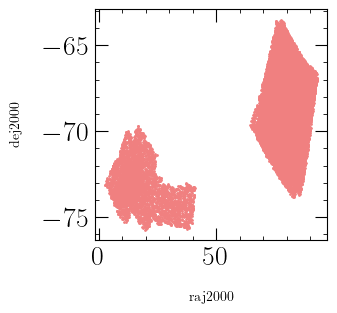

In [20]:
fig, ax = plt.subplots(1)
fig.set_size_inches(3,3)
ax.set_xlabel('raj2000', fontsize=10)
ax.set_ylabel('dej2000', fontsize=10)
ax.scatter(sage.raj2000.evaluate(), sage.dej2000.evaluate(), s=1);

In [21]:
#select sources in LMC only, filter out rows with nan for necessary data,
#with px/px_err <= 5 per Gaia collab 2021 - Structure and properties of the Magellanic Clouds
sage.select('(raj2000 > 50) &'
            '(jmag == jmag) & (hmag == hmag) & (col__3_6_ == col__3_6_) & '
            '(phot_g_mean_mag == phot_g_mean_mag) & (bp_rp == bp_rp) & '
            '(pm == pm) & (parallax_over_error <= 5)',
            name='clean')

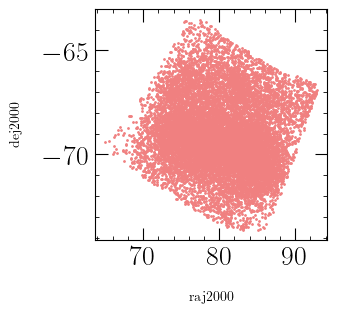

In [22]:
fig, ax = plt.subplots(1)
fig.set_size_inches(3,3)
ax.set_xlabel('raj2000', fontsize=10)
ax.set_ylabel('dej2000', fontsize=10)
ax.scatter(sage.raj2000.evaluate(selection='clean'), sage.dej2000.evaluate(selection='clean'), s=1);

In [23]:
pm_over_er = sage.pm.evaluate(selection='clean') / (sage.pmra_error.evaluate(selection='clean') + sage.pmdec_error.evaluate(selection='clean'))
pm_er = sage.pmra_error.evaluate(selection='clean') + sage.pmdec_error.evaluate(selection='clean')
pm = sage.pm.evaluate(selection='clean')

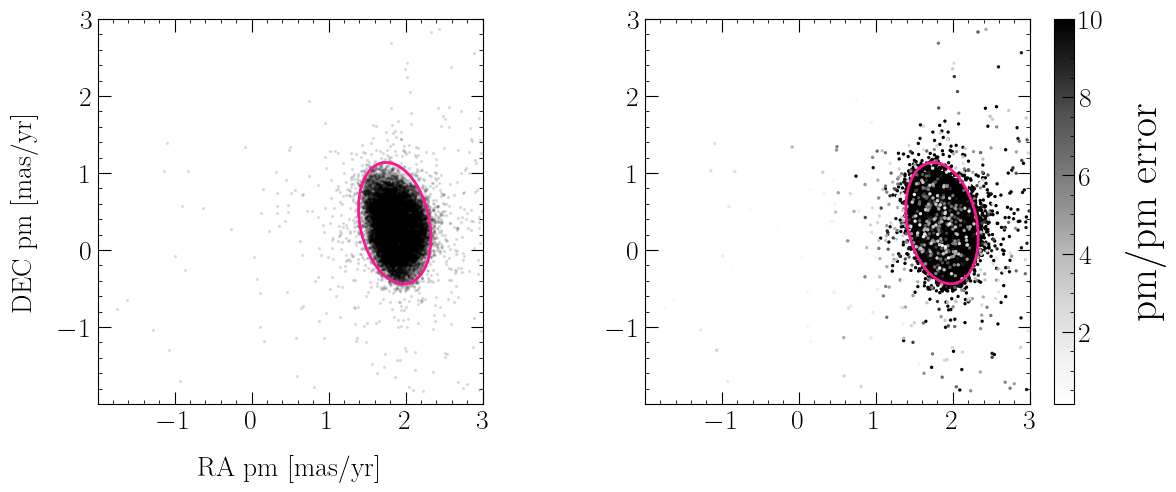

In [114]:
fig, (ax, ax2) = plt.subplots(1,2)
fig.set_size_inches(14,5)

ax.set_aspect(1)
ax.scatter(sage.pmra.evaluate(selection='clean'), sage.pmdec.evaluate(selection='clean'), s=2, 
                     color='black', alpha=0.1)

ax.set_xlim(-2,3)
ax.set_ylim(-2,3)
ax.set_xticks([-1, 0, 1, 2, 3])
ax.set_yticks([-1, 0, 1, 2, 3])

ax.set_xlabel('RA pm [mas/yr]', fontsize=20)
ax.set_ylabel('DEC pm [mas/yr]', fontsize=20)

pm_patch = mpl.patches.Ellipse((1.86, 0.35), width=0.9, height=1.6, angle=12, 
                              edgecolor='deeppink', facecolor='none', 
                              linewidth=2)
ptch2 = copy.copy(pm_patch)
ax.add_patch(pm_patch);

ax2.set_aspect(1)
col = pm_over_er
ss = np.argsort(col)[::-1]
cplot = ax2.scatter(sage.pmra.evaluate(selection='clean')[ss], sage.pmdec.evaluate(selection='clean')[ss], s=2, 
            c=col[ss], cmap='Greys', vmax=10)

ax2.set_xlim(-2,3)
ax2.set_ylim(-2,3)
ax2.set_xticks([-1, 0, 1, 2, 3])
ax2.set_yticks([-1, 0, 1, 2, 3])
ax2.add_patch(ptch2)

plt.colorbar(cplot, ax=ax2, label='pm/pm error');

In [25]:
pm_path = pm_patch.get_path()
pm_transform = pm_patch.get_patch_transform()
lmc_pm_path = pm_transform.transform_path(pm_path)
pm_points = np.stack([sage.pmra.evaluate(selection='clean'), sage.pmdec.evaluate(selection='clean')], axis=1)
lmc_pms, = np.where(lmc_pm_path.contains_points(pm_points))
out, = np.where(~lmc_pm_path.contains_points(pm_points))

In [26]:
jmag, hmag = sage.jmag.evaluate(selection='clean')[lmc_pms], sage.hmag.evaluate(selection='clean')[lmc_pms], 
_36mag = sage.col__3_6_.evaluate(selection='clean')[lmc_pms] 
gmag, bprp = sage.phot_g_mean_mag.evaluate(selection='clean')[lmc_pms], sage.bp_rp.evaluate(selection='clean')[lmc_pms]
jh = jmag - hmag
h36 = hmag - _36mag

In [27]:
len(lmc_pms), len(sage.jmag.evaluate(selection='clean'))

(14948, 15971)

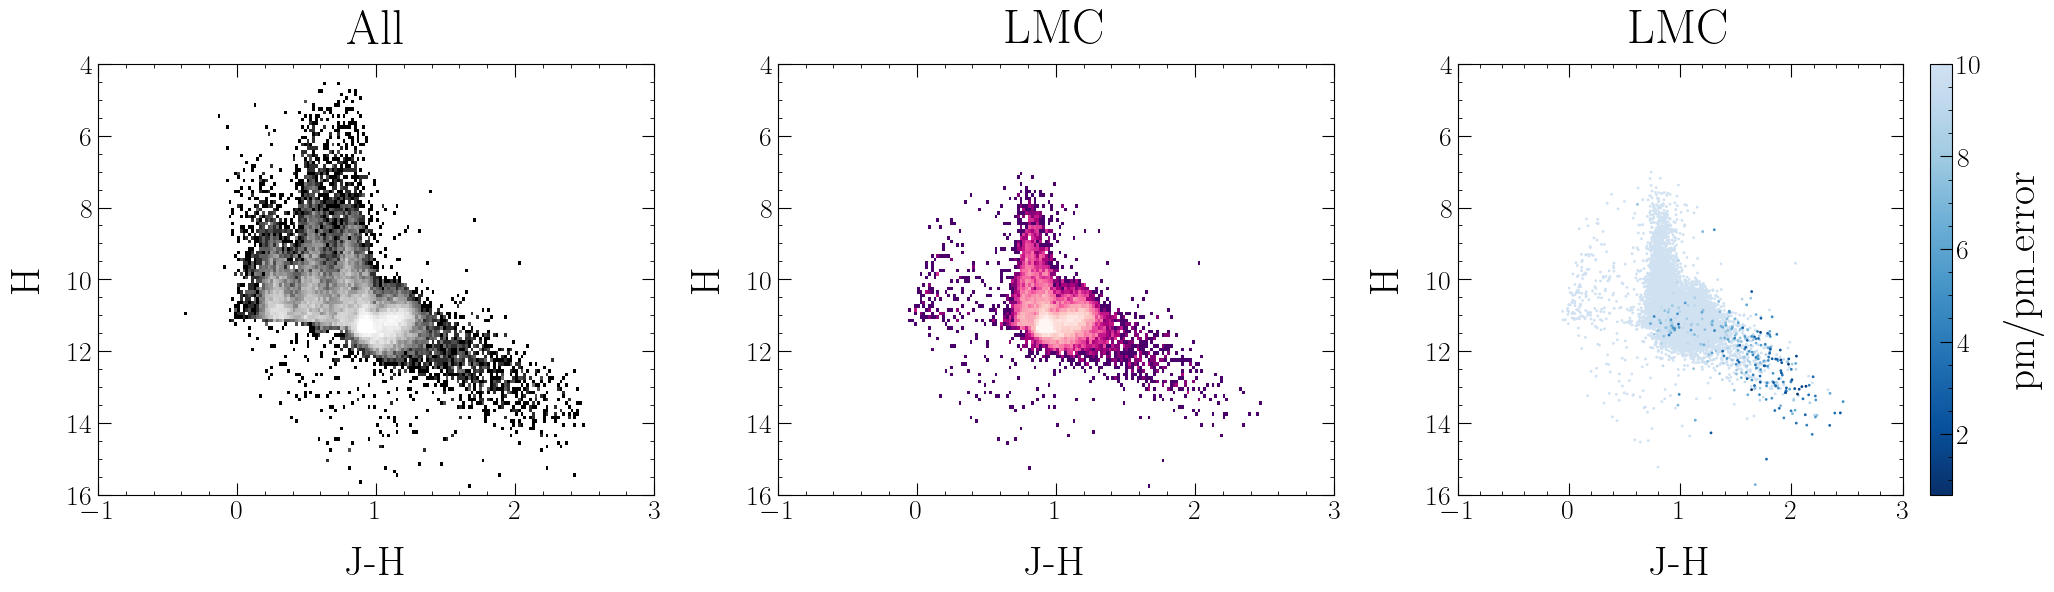

In [28]:
fig, (ax, ax2, ax3) = plt.subplots(1,3)
fig.set_size_inches(20,5)
fig.tight_layout(w_pad=5)

cmd_range = [[-0.5,2.5],[4,16]]
cmd_bins = [150, 120]
            
cmap1 = copy.copy(mpl.cm.get_cmap('Greys_r'))
cmap1.set_under('w')

ax.hist2d(sage.jmag.evaluate() - sage.hmag.evaluate(), sage.hmag.evaluate(),
          bins=cmd_bins, range=cmd_range, 
          norm=mpl.colors.LogNorm(vmin=1e0, vmax=1e2), cmap=cmap1)

ax.set_xlim(-1, 3)
ax.set_ylim(4,16)
ax.invert_yaxis()
ax.set_title('All')
ax.set_xlabel('J-H')
ax.set_ylabel('H')

cmap2 = copy.copy(mpl.cm.get_cmap('RdPu_r'))
cmap2.set_under('w')
ax2.hist2d(jh, hmag,  
           cmap=cmap2, norm=mpl.colors.LogNorm(vmin=1e0, vmax=1e2),
           bins=cmd_bins, range=cmd_range)


ax2.set_xlim(-1, 3)
ax2.set_ylim(4,16)
ax2.invert_yaxis()
ax2.set_title('LMC')
ax2.set_xlabel('J-H')
ax2.set_ylabel('H');
#ax2.legend(loc=0, markerscale=5);

cmap3 = cm.get_sub_cmap('Blues_r', 0.0, 0.8)
cmap3.set_under('w')
ss = np.argsort(pm_over_er[lmc_pms])[::-1]
er_plot = ax3.scatter(jh[ss], hmag[ss],  
           c=pm_over_er[lmc_pms][ss], cmap=cmap3, vmax=10, s=1)


ax3.set_xlim(-1, 3)
ax3.set_ylim(4,16)
ax3.invert_yaxis()
ax3.set_title('LMC')
ax3.set_xlabel('J-H')
ax3.set_ylabel('H');

plt.colorbar(er_plot, ax=ax3, label='pm/pm_error');

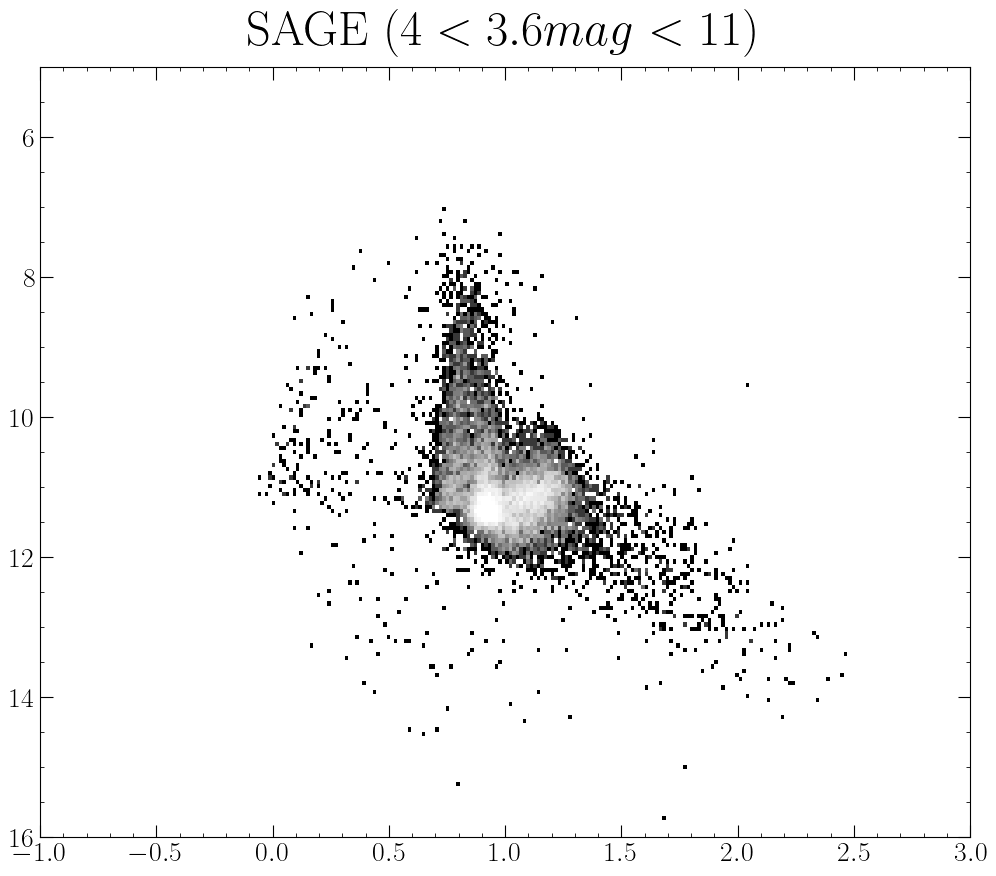

In [29]:
plt.clf()

from matplotlib.widgets import LassoSelector
%matplotlib inline

path_pts = []
def on_select(x):
    path_pts.append(x)
    

line_props={'color':'deeppink', 
            'linewidth':2
           }
    
fig, ax = plt.subplots(1)
fig.set_size_inches(12,10)

cmd_range = [[-0.5,2.5],[4,16]]
cmd_bins = [200,200]
cmap2 = copy.copy(mpl.cm.get_cmap('Greys_r'))
cmap2.set_under('w')
ax.hist2d(jh, hmag, 
           cmap=cmap2, norm=mpl.colors.LogNorm(vmin=1e0, vmax=50), 
           bins=cmd_bins, range=cmd_range)#c='blue', s=5, label='$4 < 3.6mag < 11$', alpha=0.2);

ax.set_xlim(-1,3)
ax.set_ylim(5,16)
ax.invert_yaxis()
ax.set_title('SAGE ($4 < 3.6mag < 11$)');

#patch1 = mpl.patches.PathPatch(Path(path_pts1), edgecolor='deeppink', facecolor='none')
#patch2 = mpl.patches.PathPatch(Path(path_pts2), edgecolor='deeppink', facecolor='none')
#patch3 = mpl.patches.PathPatch(Path(path_pts3), edgecolor='deeppink', facecolor='none')
#patch4 = mpl.patches.PathPatch(Path(path_pts4), edgecolor='deeppink', facecolor='none')
#patch5 = mpl.patches.PathPatch(Path(path_pts5), edgecolor='deeppink', facecolor='none')
#patch6 = mpl.patches.PathPatch(Path(path_pts6), edgecolor='deeppink', facecolor='none')
#patch7 = mpl.patches.PathPatch(Path(path_pts7), edgecolor='deeppink', facecolor='none')
#patch8 = mpl.patches.PathPatch(Path(path_pts8), edgecolor='deeppink', facecolor='none')
#patch9 = mpl.patches.PathPatch(Path(path_pts9), edgecolor='deeppink', facecolor='none')

#ptchs = [patch1, patch2, patch3, patch4, patch5, patch6, patch7, patch8]

#for p in ptchs:
#    ax.add_patch(p);

lasso = LassoSelector(ax=ax, onselect=on_select, props=line_props, button=1);

In [30]:
np.shape(path_pts)

(0,)

In [31]:
#path_pts1 = np.reshape(path_pts, (389,2))

In [32]:
#path_pts2 = np.reshape(path_pts, (406,2))

In [33]:
#path_pts3 = np.reshape(path_pts, (383,2))

In [34]:
#path_pts4 = np.reshape(path_pts, (213,2))

In [35]:
#path_pts5 = np.reshape(path_pts, (484,2))

In [36]:
#path_pts6 = np.reshape(path_pts, (479,2))

In [37]:
#path_pts7 = np.reshape(path_pts, (548,2))

In [38]:
#path_pts8 = np.reshape(path_pts, (560,2))

In [39]:
#path_dict = {'p1': path_pts1, 
#             'p2': path_pts2, 
#             'p3': path_pts3, 
#             'p4': path_pts4, 
#             'p5': path_pts5, 
#             'p6': path_pts6,
#             'p7': path_pts7,
#             'p8': path_pts8
#            }

In [40]:
import pickle

#with open('path_dict.pickle', 'wb') as f:
#    # Pickle the dictionary using the highest protocol available.
#    pickle.dump(path_dict, f, pickle.HIGHEST_PROTOCOL)

with open('path_dict.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    path_dict = pickle.load(f)

In [41]:
patch1 = mpl.patches.PathPatch(Path(path_dict['p1']), edgecolor='deeppink', facecolor='none')
patch2 = mpl.patches.PathPatch(Path(path_dict['p2']), edgecolor='deeppink', facecolor='none')
patch3 = mpl.patches.PathPatch(Path(path_dict['p3']), edgecolor='deeppink', facecolor='none')
patch4 = mpl.patches.PathPatch(Path(path_dict['p4']), edgecolor='deeppink', facecolor='none')
patch5 = mpl.patches.PathPatch(Path(path_dict['p5']), edgecolor='deeppink', facecolor='none')
patch6 = mpl.patches.PathPatch(Path(path_dict['p6']), edgecolor='deeppink', facecolor='none')
patch7 = mpl.patches.PathPatch(Path(path_dict['p7']), edgecolor='deeppink', facecolor='none')
patch8 = mpl.patches.PathPatch(Path(path_dict['p8']), edgecolor='deeppink', facecolor='none')

In [42]:
ptchs = [patch1, patch2, patch3, patch4, patch5, patch6, patch7, patch8]

<Figure size 700x700 with 0 Axes>

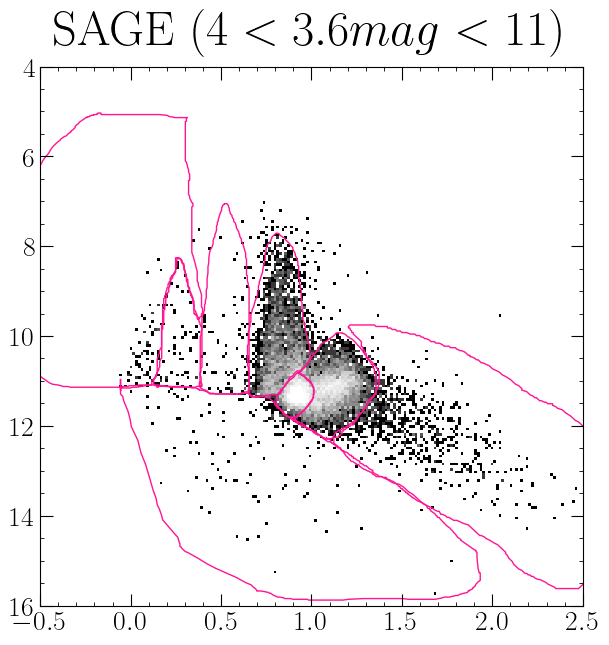

In [43]:
plt.clf()
fig, ax = plt.subplots(1)

cmd_range = [[-0.5,2.5],[4,16]]
cmd_bins = [200,200]
cmap2 = copy.copy(mpl.cm.get_cmap('Greys_r'))
cmap2.set_under('w')
ax.hist2d(jh, hmag, 
           cmap=cmap2, norm=mpl.colors.LogNorm(vmin=1e0, vmax=50), 
           bins=cmd_bins, range=cmd_range)#c='blue', s=5, label='$4 < 3.6mag < 11$', alpha=0.2);

#ax.set_xlim(0, 2.5)
#ax.set_ylim(6,15)
ax.invert_yaxis()
ax.set_title('SAGE ($4 < 3.6mag < 11$)');

for p in ptchs:
    ax.add_patch(p);

In [44]:
pts_jh = np.stack((jh, hmag), axis=1)
pts_jh

array([[ 0.90000057, 11.45699978],
       [ 0.92700005, 11.42000008],
       [ 1.1449995 , 11.58600044],
       ...,
       [ 0.956     , 11.039     ],
       [ 0.943     , 11.369     ],
       [ 1.172     , 10.81      ]])

In [45]:
grp1, = np.where(Path(path_dict['p1']).contains_points(pts_jh))
grp2, = np.where(Path(path_dict['p2']).contains_points(pts_jh))
grp3, = np.where(Path(path_dict['p3']).contains_points(pts_jh))
grp4, = np.where(Path(path_dict['p4']).contains_points(pts_jh))
grp5, = np.where(Path(path_dict['p5']).contains_points(pts_jh))
grp6, = np.where(Path(path_dict['p6']).contains_points(pts_jh))
grp7, = np.where(Path(path_dict['p7']).contains_points(pts_jh))
grp8, = np.where(Path(path_dict['p8']).contains_points(pts_jh))

grps = [grp1, grp2, grp3, grp4, grp5, grp6, grp7, grp8]

In [46]:
vals = np.full_like(jh, 0)
cols = np.full(np.shape(jh), 'aaaaaaaaaaaaaaaa')
colors = ['grey', 'orangered', 'deepskyblue','darkorange', 'blueviolet', 'gold', 'magenta', 'limegreen', 'deeppink']
for i in range(8):
    vals[grps[i]] = i + 1
    cols[grps[i]] = colors[i]

In [47]:
no_col, = np.where(cols == 'aaaaaaaaaaaaaaaa')
cols[no_col] = 'none'

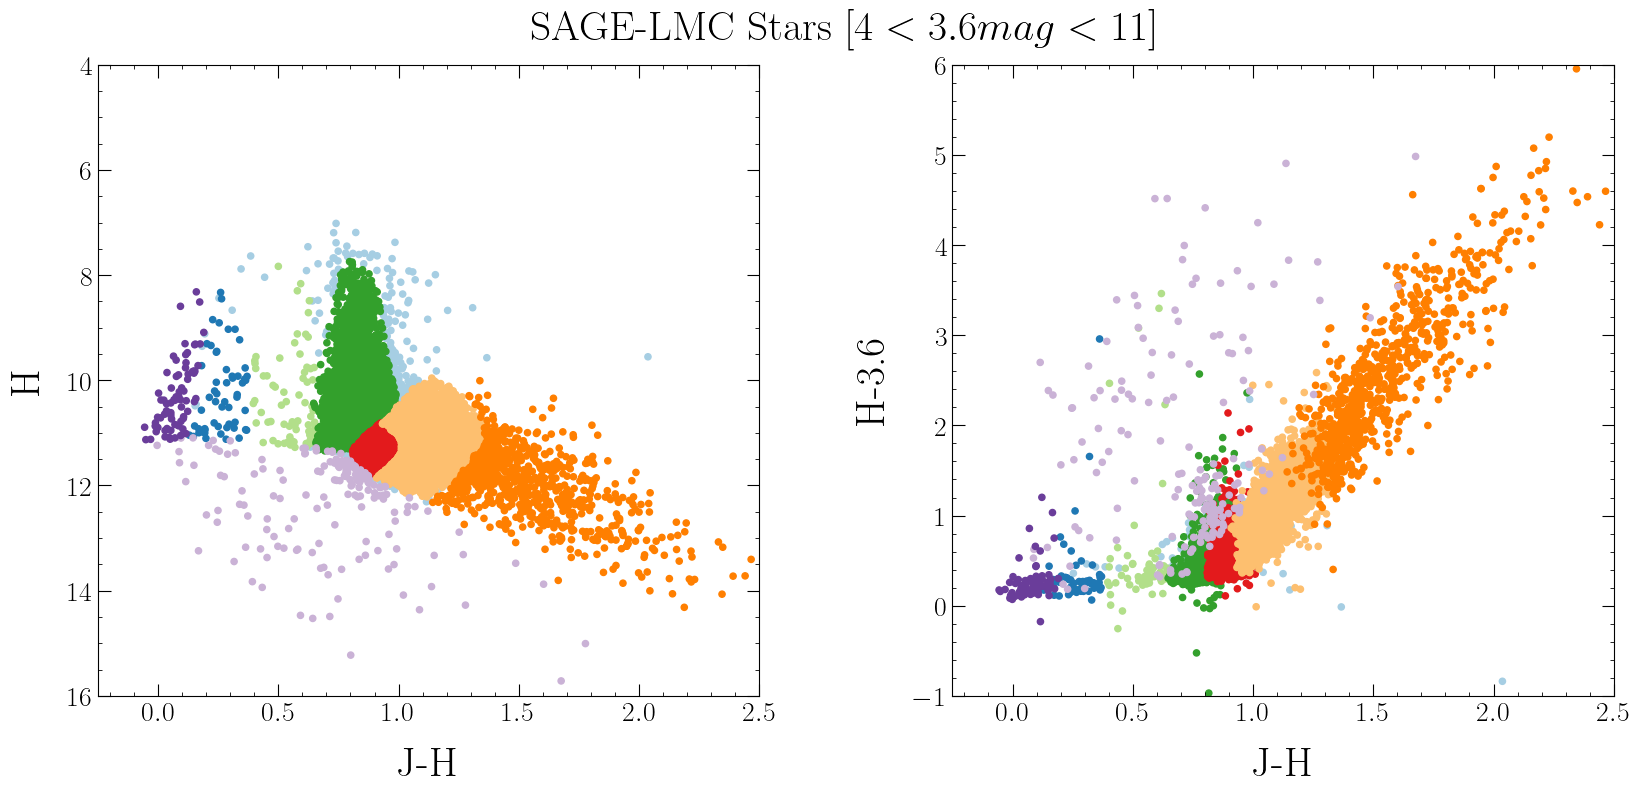

In [48]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,7)
fig.tight_layout(w_pad=10)

cmap = cm.get_sub_cmap('Paired', 0.0, 0.8)

#ax1.set_aspect(1/3)
ss = np.argsort(vals)
plot = ax1.scatter(jh[ss], hmag[ss], c=vals[ss], cmap=cmap, s=20)
ax1.set_xlabel('J-H')
ax1.set_ylabel('H')
ax1.set_xlim(-0.25, 2.5)
ax1.set_ylim(4,16)
ax1.invert_yaxis()


#ax2.set_aspect(2/3)
ax2.scatter(jh[ss], h36[ss], c=vals[ss], cmap=cmap, s=20)
ax2.set_xlim(-0.25,2.5)
ax2.set_ylim(-1,6)
ax2.set_xlabel('J-H')
ax2.set_ylabel('H-3.6');

#cax = fig.add_axes([1.0, 0.0, 0.05, 0.9])
#plt.colorbar(plot, cax=cax);
fig.text(0.5, 1.0 ,'SAGE-LMC Stars [$4 < 3.6mag < 11$]', fontsize=30, ha='center');

In [49]:
bins = 100

lmc_hist = np.histogram2d(jh, h36, bins=bins)

#list of median, mean, & std of hw1 values of a given slice
running_median = []
running_mean = []
running_std = []
#index values that have a usable mean
nz = []
#how many data points contribute to each median
wts = []
for i in range(bins):
    #finds the hw1 values for a given one-bin-width-slice of jh
    window = h36[np.where((jh >= lmc_hist[1][i]) 
                            & (jh < lmc_hist[1][i+1]))]
    ws = window.size
    if ws > 2:
        median = np.median(window)
        mean = np.mean(window)
        std = np.std(window)
        
        running_median.append(median)
        running_mean.append(mean)
        running_std.append(std)
        nz.append(i)
        wts.append(ws)

running_median = np.array(running_median)
running_mean = np.array(running_mean)
running_std = np.array(running_std)
wts = np.array(wts)

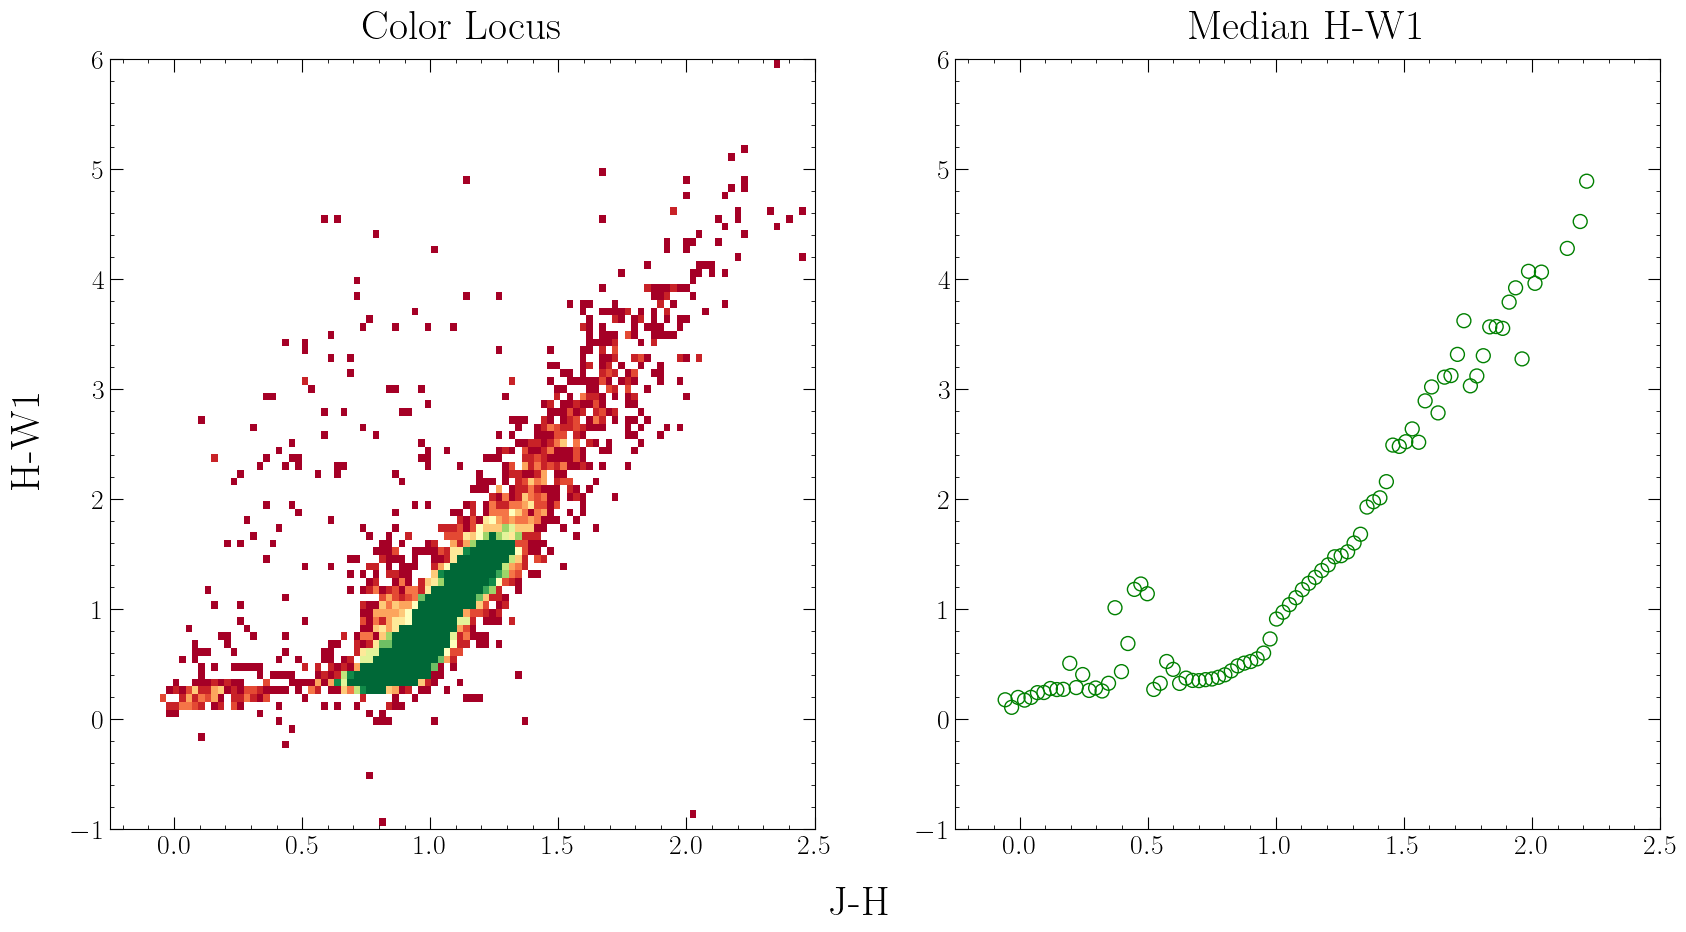

In [50]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

lmc_colcol = ax[0].hist2d(jh, h36, 
                    cmap='RdYlGn', vmin=1, vmax=15,
                    bins=bins, cmin=1)

ax[0].set_title('Color Locus', fontsize=30)
ax[0].set_xlim(-0.25,2.5)
ax[0].set_ylim(-1,6);

ss = np.argsort(wts)
ax[1].scatter(lmc_hist[1][nz][ss], running_median[ss], 
              s=100, marker='o', linewidth=1,
              edgecolor='green', facecolor='none',
           )
ax[1].set_xlim(-0.25,2.5)
ax[1].set_ylim(-1,6);
ax[1].set_title('Median H-W1', fontsize=30)


fig.text(0.075, 0.5, 'H-W1', rotation='vertical', verticalalignment='center', fontsize=30);
fig.text(0.5, 0.025, 'J-H', horizontalalignment='center', fontsize=30);

plt.savefig('./images/lmc_col_locus.png', bbox_inches='tight')

In [51]:
#define x data for spline fits
xs = lmc_colcol[1][:-1][nz]
good, = np.where(xs >= 0.)

#run spline fits
sqr_spline = spline(xs[good], running_median[good], k=2)
cube_spline = spline(xs[good], running_median[good], k=3)
#larger s = more smoothing
#con = spline(xs, running_median, s=1)

In [52]:
xx = np.linspace(0.,2.2,1000)

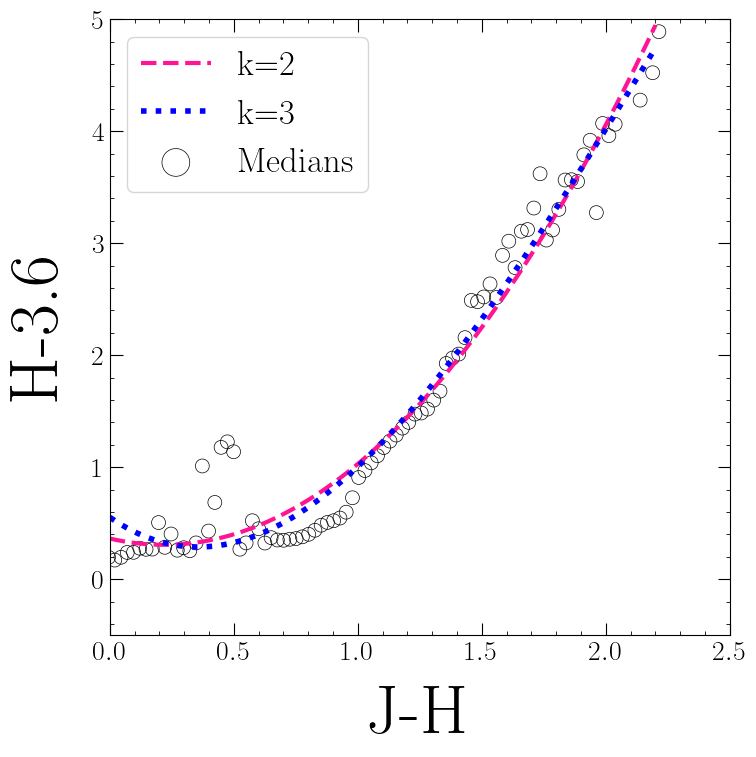

In [53]:
fig, ax = plt.subplots(1)
fig.set_size_inches(8,8)

ax.set_xlim(0, 2.5)
ax.set_ylim(-0.5,5)
ax.set_xlabel('J-H', fontsize=50)
ax.set_ylabel('H-3.6', fontsize=50)


ax.plot(xx, sqr_spline(xx), linewidth=3, linestyle='--', label='k=2', c='deeppink')
ax.plot(xx, cube_spline(xx), linewidth=4, linestyle=':', label='k=3', c='blue')
ax.scatter(xs, running_median, edgecolor='black', facecolor='none', s=100, linewidth=0.5, label='Medians');

ax.legend(loc='best', markerscale=2, fontsize=25);

plt.savefig('./images/col_loc_fits.png', bbox_inches='tight')

In [54]:
mosaic = [['JH panel', 'JH panel', 'JH panel', '.'],
          ['main plot', 'main plot', 'main plot', 'H36 panel'],
          ['main plot', 'main plot', 'main plot', 'H36 panel'],
          ['main plot', 'main plot', 'main plot',  'H36 panel'],
          ['sigma panel', 'sigma panel', 'sigma panel',  '.']
    
]

In [55]:
zrs, = np.where((jh == 0) & (h36 == 0))

In [56]:
jh_xs = np.linspace(-0.5, 3.0, len(jh))
h36_xs = np.linspace(-1, 6, len(jh))

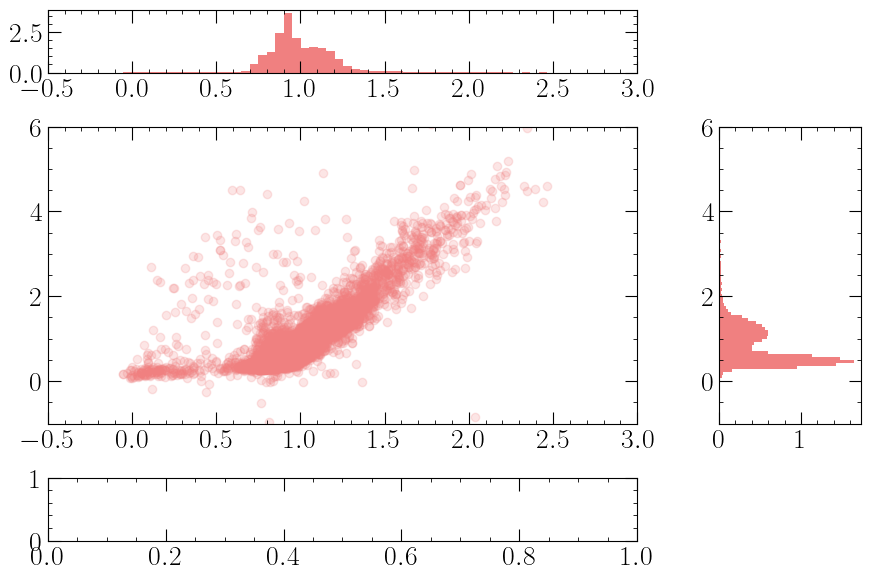

In [57]:
#try separating the top/side panels into curves of stellar types
fig, axs = plt.subplot_mosaic(mosaic#, width_ratios=[1, 1, 0.25], height_ratios=[0.25, 1, 1, 0.25]
        )
fig.set_size_inches(9,6)
fig.tight_layout()

axs['main plot'].scatter(jh, h36, alpha=0.2);
axs['main plot'].set_xlim(-0.5,3.0)
axs['main plot'].set_ylim(-1,6)

axs['JH panel'].set_xlim(-0.5,3.0)
axs['JH panel'].hist(jh, bins=50, density=True)

axs['H36 panel'].set_ylim(-1,6)
axs['H36 panel'].hist(h36, bins=100, density=True, orientation='horizontal');

In [58]:
x1 = np.linspace(-1.0, 1.14, 1000)
x2 = np.linspace(1.16, 2.5, 1000)
y1 = np.repeat(19.48, 1000)
y2 = 2 * x2 + 17.18

In [59]:
xs = np.concatenate((x1,x2), axis=0)
ys = np.concatenate((y1,y2), axis=0)

In [60]:
xg1 = np.linspace(-1.0, 1.2, 1000)
xg2 = np.linspace(1.2, 3, 1000)
yg1 = np.repeat(19.28, 1000)
yg2 = 2 * xg2 + 16.88

In [61]:
gxs = np.concatenate((xg1,xg2), axis=0)
gys = np.concatenate((yg1,yg2), axis=0)

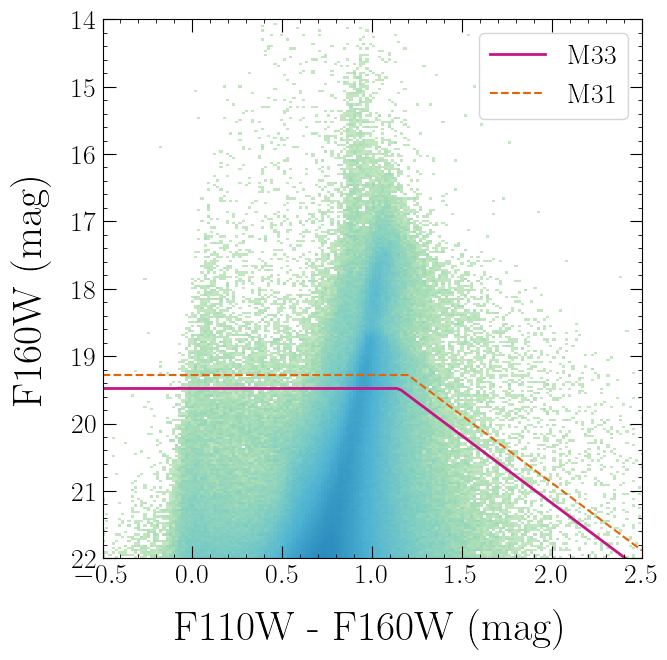

In [62]:
fig, ax = plt.subplots(1)

ax.set_aspect(3/8)


cmd = ax.hist2d(phatter.F110W_F160W.evaluate(), phatter.F160W_VEGA.evaluate(),
          bins=400,
          norm=mpl.colors.LogNorm(vmin=1e-2,vmax=1e5), 
          cmap='GnBu')
ax.plot(xs, ys, c='mediumvioletred', linestyle='-', linewidth=2, 
        label='M33' 
       )

ax.plot(gxs, gys, c='#E76404', linestyle='--', linewidth=1.5, 
        label='M31'
       )

ax.set_xlabel('F110W - F160W (mag)')
ax.set_ylabel('F160W (mag)')
ax.set_ylim(22,14)
ax.set_xlim(-0.5,2.5)

ax.legend(loc='best');

plt.savefig('./images/goldman_cut.png', bbox_inches='tight')

In [63]:
def linear_hst_to_jh(f110_f160):
    lin_jh = -0.4464 + (1.2991 * f110_f160)
    return lin_jh

def dalcanton_jh(f110_f160):
    j_h = 0.9418 + 0.841*(f110_f160-1.0) - 0.9053*(f110_f160-1.0)**2
    return j_h

tc = np.linspace(-1, 3, 1000)

In [64]:
gst_110, gst_160 = phatter.F110W_VEGA.evaluate(), phatter.F160W_VEGA.evaluate()

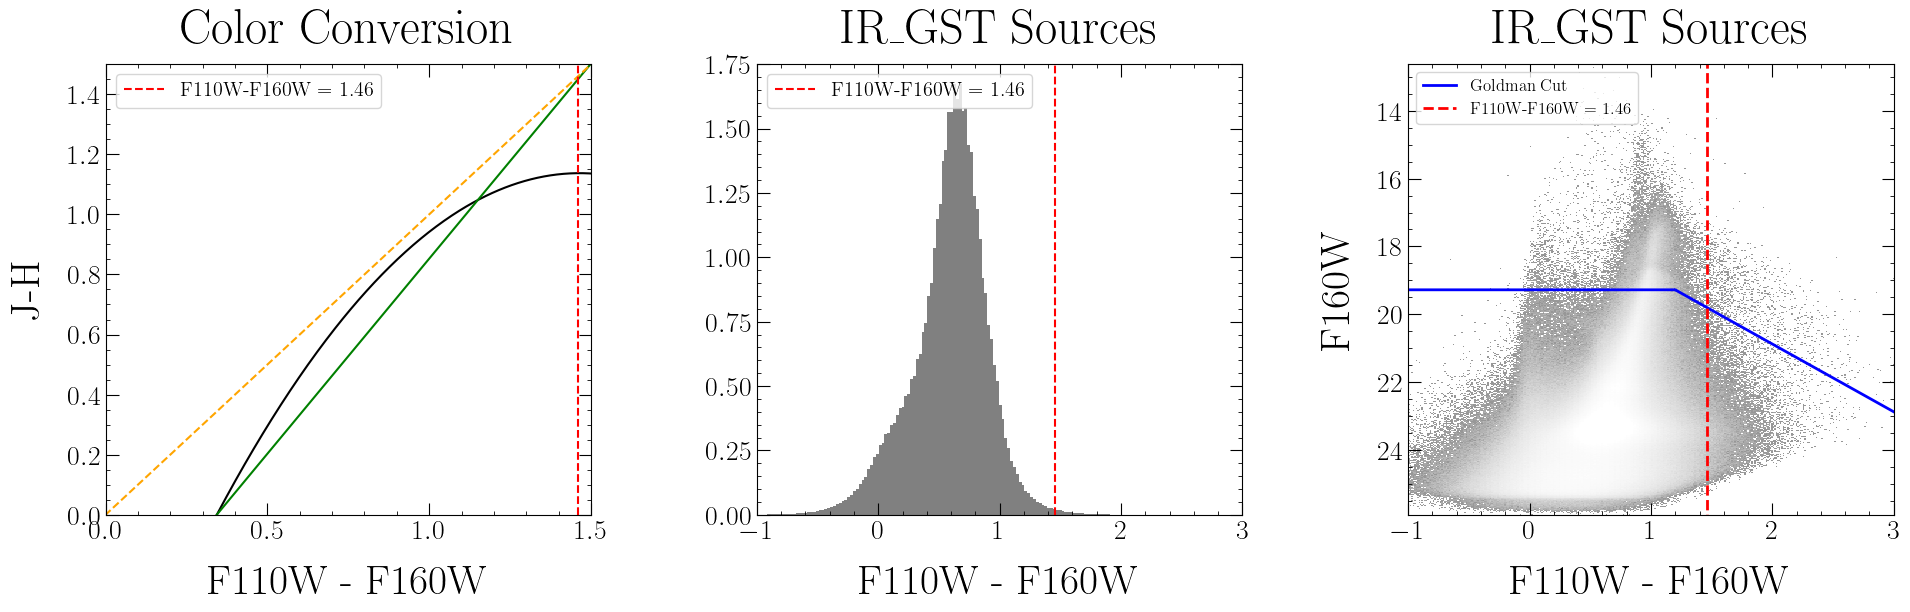

In [65]:
fig, (ax2, ax1, ax3) = plt.subplots(1,3)
fig.tight_layout(w_pad=1)
fig.set_size_inches(20,5)

ax1.hist(gst_110 - gst_160, bins=300, density=True, color='grey')
ax1.set_xlim(-1, 3)
ax1.set_ylim(0, 1.75)
ax1.set_xlabel('F110W - F160W')
ax1.vlines(1.46, 0, 2, color='red', linestyle='--', label='F110W-F160W = 1.46')
ax1.set_title('IR\_GST Sources')
ax1.legend(loc='upper left', fontsize='x-large')

ax2.plot(tc, dalcanton_jh(tc),
           color='black')
ax2.plot(tc, linear_hst_to_jh(tc), color='green')
ax2.plot(tc, tc, color='orange', linestyle='--')
ax2.set_xlabel('F110W - F160W')
ax2.set_ylabel('J-H');
ax2.set_xlim(0, 1.5)
ax2.set_ylim(0, 1.5);
ax2.vlines(1.46, 0, 1.5, color='red', linestyle='--', label='F110W-F160W = 1.46')
ax2.set_title('Color Conversion')
ax2.legend(loc='upper left', fontsize='x-large')


ax3.hist2d(gst_110 - gst_160, gst_160, 
           bins=600, cmap='Greys_r', cmin=1, norm=mpl.colors.LogNorm(vmin=1e-1, vmax=1e3), alpha=0.6);
ax3.plot(gxs, gys, c='blue', linestyle='-', linewidth=2, label='Goldman Cut'
       )
ax3.vlines(1.46, 10,30,color='red', linestyle='--', linewidth=2, label='F110W-F160W = 1.46')
ax3.invert_yaxis();
ax3.set_xlim(-1,3);
ax3.set_xlabel('F110W - F160W');
ax3.set_ylabel('F160W');
ax3.set_title('IR\_GST Sources');
ax3.legend(loc='upper left', fontsize='large');

#plt.savefig('./images/jh_conversion_curve.png', bbox_inches='tight')

In [66]:
phatter.head(2)

#,RA,DEC,X,Y,F475W_COUNT,F475W_SKY,F475W_RATE,F475W_RATERR,F475W_VEGA,F475W_TRANS,F475W_ERR,F475W_CHI,F475W_SNR,F475W_SHARP,F475W_ROUND,F475W_CROWD,F475W_FLAG,F814W_COUNT,F814W_SKY,F814W_RATE,F814W_RATERR,F814W_VEGA,F814W_TRANS,F814W_ERR,F814W_CHI,F814W_SNR,F814W_SHARP,F814W_ROUND,F814W_CROWD,F814W_FLAG,F275W_COUNT,F275W_SKY,F275W_RATE,F275W_RATERR,F275W_VEGA,F275W_TRANS,F275W_ERR,F275W_CHI,F275W_SNR,F275W_SHARP,F275W_ROUND,F275W_CROWD,F275W_FLAG,F336W_COUNT,F336W_SKY,F336W_RATE,F336W_RATERR,F336W_VEGA,F336W_TRANS,F336W_ERR,F336W_CHI,F336W_SNR,F336W_SHARP,F336W_ROUND,F336W_CROWD,F336W_FLAG,F110W_COUNT,F110W_SKY,F110W_RATE,F110W_RATERR,F110W_VEGA,F110W_TRANS,F110W_ERR,F110W_CHI,F110W_SNR,F110W_SHARP,F110W_ROUND,F110W_CROWD,F110W_FLAG,F160W_COUNT,F160W_SKY,F160W_RATE,F160W_RATERR,F160W_VEGA,F160W_TRANS,F160W_ERR,F160W_CHI,F160W_SNR,F160W_SHARP,F160W_ROUND,F160W_CROWD,F160W_FLAG,index,F275W_ST_FLAG,F275W_GST_FLAG,F336W_ST_FLAG,F336W_GST_FLAG,F475W_ST_FLAG,F475W_GST_FLAG,F814W_ST_FLAG,F814W_GST_FLAG,F110W_ST_FLAG,F110W_GST_FLAG,F160W_ST_FLAG,F160W_GST_FLAG,n_detected,DENSITY,INDEX,F110W_F160W
<i style='opacity: 0.6'>0</i>,23.6539,30.7727,2594.31,9800.04,0,0,0,9999,nan,nan,9.999,0,0,0,0,0,0,0,0,0,9999,nan,nan,9.999,0,0,0,0,0,0,0,0,0,9999,nan,nan,9.999,0,0,0,0,0,0,0,0,0,9999,nan,nan,9.999,0,0,0,0,0,0,0,0,0,9999,nan,nan,9.999,0,0,0,0,0,0,0,0,0,9999,nan,nan,9.999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0254279,0,nan
<i style='opacity: 0.6'>1</i>,23.6539,30.7727,2592.6,9800.4,0,0,0,9999,nan,nan,9.999,0,0,0,0,0,0,0,0,0,9999,nan,nan,9.999,0,0,0,0,0,0,0,0,0,9999,nan,nan,9.999,0,0,0,0,0,0,0,0,0,9999,nan,nan,9.999,0,0,0,0,0,0,0,0,0,9999,nan,nan,9.999,0,0,0,0,0,0,0,0,0,9999,nan,nan,9.999,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0253243,1,nan


In [67]:
def linear_jh(f110, f160):
    #linear approximation from above
    lin_jh = -0.4464 + (1.2991 * (f110 - f160))
    return lin_jh

def convert_to_JH(f110w,f160w):
    #conversion from Dalcanton, 2012 - not valid for full range
    #NOT USING
    j_h = 0.9418 + 0.841*(f110w-f160w-1.0) - 0.9053*(f110w-f160w-1.0)**2
    return j_h

#old conversion from Dalcanton 2012
#def HST_to_2MASS(f110w,f160w):
#    f160w_h = 0.2031 + 0.401*(convert_to_JH(f110w,f160w) - 0.9) + 0.3498*(convert_to_JH(f110w,f160w) - 0.9)**2
#    h = f160w - f160w_h
#    j = h + convert_to_JH(f110w,f160w)
#    return j,h

#new conversion using linear fit
def HST_to_2MASS(f110w,f160w):
    f160w_h = 0.2031 + 0.401*(linear_jh(f110w,f160w) - 0.9) + 0.3498*(linear_jh(f110w,f160w) - 0.9)**2
    h = f160w - f160w_h
    j = h + linear_jh(f110w,f160w)
    return j,h

###Define J and H for ph_data sources and add to dataframe

phatter['J_MAG'], phatter['H_MAG'] = HST_to_2MASS(phatter['F110W_VEGA'], phatter['F160W_VEGA'])

phatter['J_H'] = phatter['J_MAG'] - phatter['H_MAG']


###Convert J-H to H-3.6 using spline fit from LMC color locus

phatter['H_36'] = cube_spline(phatter.J_H.evaluate())

phatter['MAG_36'] = phatter['H_MAG'] - phatter['H_36']

###Convert 3.6 magnitude to flux density and add column to data
phatter['FD_36'] = spitzer_mag_to_fd(phatter['MAG_36'])

In [68]:
spitzer['fd36'] = spitzer_mag_to_fd(spitzer['mag36'])

In [69]:
#Color cuts to PHATTER sample following criteria from Goldman, et al 2022
#Cuts in J-H provided by the goodness of fit of the col-col spline above

phatter.select('IR_GST & ' 
               '(J_H > 0.0) & (J_H < 2.2) & '
               '(((F160W_VEGA < 19.48) & (F110W_VEGA - F160W_VEGA < 1.15)) | '
               '((F110W_VEGA - F160W_VEGA >= 1.15) & (F160W_VEGA < 2 * (F110W_VEGA - F160W_VEGA) + 17.18)))',
               name='COL_CUT')

In [70]:
index_colcut = phatter.INDEX.evaluate(selection='COL_CUT')
RA,DEC = phatter.RA.evaluate(selection='COL_CUT'), phatter.DEC.evaluate(selection='COL_CUT')

## Matching Process

In [81]:
###Spitzer RA and DEC
xu, yu = np.array(spitzer['ra']), np.array(spitzer['dec'])

In [82]:
num_ras, num_decs = ceil((np.max(xu) - np.min(xu)) / (2/3600)), ceil((np.max(yu) - np.min(yu)) / (2/3600))
num_ras, num_decs

(576, 650)

In [83]:
ra_bins = np.linspace(np.min(xu), np.max(xu), num_ras)
dec_bins = np.linspace(np.min(yu), np.max(yu), num_decs)

In [84]:
histu,hx,hy = np.histogram2d(xu, yu, bins=[ra_bins, dec_bins])
indu = ri.get_indices(histu, xu, yu, x_bins=hx, y_bins=hy)

In [85]:
len(indu)

25921

In [86]:
histp,hxx,hyy = np.histogram2d(RA,DEC, bins=[hx,hy])
indp = ri.get_indices(histp, RA,DEC, x_bins=hx, y_bins=hy)

In [87]:
hist_gst,_,_ = np.histogram2d(ra_gst, dec_gst, bins=[hx,hy])
indgst =  ri.get_indices(hist_gst, ra_gst, dec_gst, x_bins=hx, y_bins=hy)

In [88]:
uu = 9617
uw = indu[uu]
p, = np.where(indp == uw)
uu, p[:5]

(9617, array([], dtype=int64))

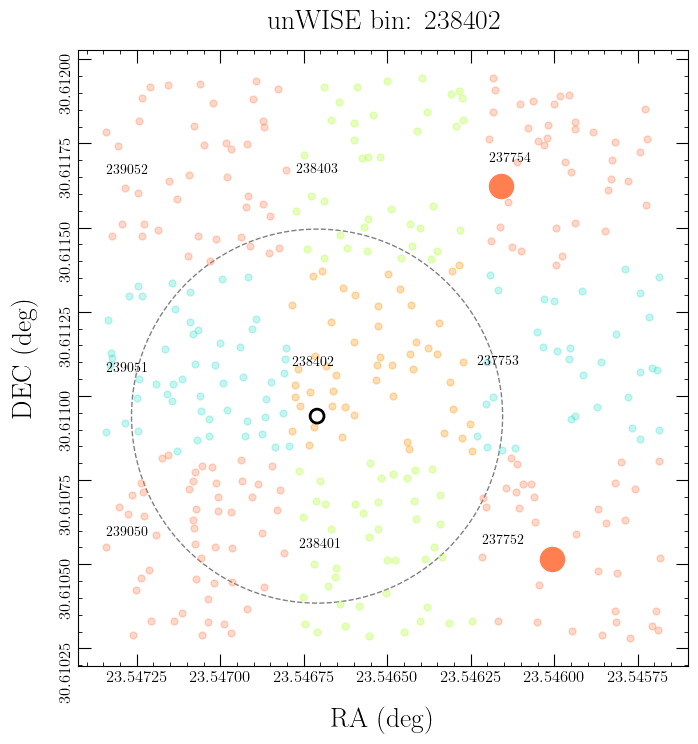

In [122]:
###Check that bin numbers are correctly aligned between the datasets
fig, ax = plt.subplots(1)
fig.set_size_inches(8,8)

bins = num_decs

ax.set_aspect(m33_ar * 10/13)
#ax.set_ylim(30.4978, 30.499)
ax.set_xlabel('RA (deg)', fontsize=20)
ax.set_ylabel('DEC (deg)', fontsize=20)
ax.set_title('unWISE bin: {}'.format(uw), fontsize=20)
ax.tick_params(axis='y', rotation=90)
ax.invert_xaxis()
ax.tick_params(axis='both', labelsize='large')

ax.scatter(spitzer['ra'][uu], spitzer['dec'][uu], 
           edgecolor='black', 
           facecolor='none', 
           marker='o',
           s=100,
           zorder=5,
           linewidths=2
          )
psf = patches.Circle((spitzer['ra'][uu], spitzer['dec'][uu]), 
                     radius=2/3600, 
                     edgecolor='gray', 
                     facecolor=(0,0,0,0),
                     linestyle='--',
                     linewidth=1)
ax.add_patch(psf)

bb = [uw, uw+1, uw-1, uw + bins - 1, uw - bins + 1, uw + bins, uw - bins, uw + bins - 2, uw - bins + 2]
#cc = ['yellowgreen', 'pink', 'pink', 'powderblue', 'powderblue', 'orange', 'orange', 'orange', 'orange']
cc = ['xkcd:tangerine', 'greenyellow', 'greenyellow', 'turquoise', 'turquoise', 'coral', 'coral', 'coral', 'coral']

for i,bin in enumerate(bb):
    lox, = np.where(indgst == bb[i])
    ax.scatter(ra_gst[lox], dec_gst[lox],
               color=cc[i], s=25, alpha=0.3)
    
    final, = np.where(indp == bb[i])
    ax.scatter(RA[final], DEC[final],
               color=cc[i], s=300)

    ax.text(np.max(ra_gst[lox]), np.mean(dec_gst[lox]),
                str(bin), fontsize=10)
    

    
#plt.savefig('./images/bin_visuals.eps', format='eps', bbox_inches='tight')

In [123]:
FD_36 = phatter.FD_36.evaluate(selection='COL_CUT')

In [124]:
MAG_36 = phatter.MAG_36.evaluate(selection='COL_CUT')

In [125]:
col = phatter.F110W_F160W.evaluate(selection='COL_CUT')

In [179]:
ar_length = len(RA)
flux_fracs = np.full(ar_length, -999.9)
mag_difs = np.full(ar_length, -999.9)
dists = np.full(ar_length, -999.9)
uw_matches = np.full(ar_length, -999)
match_ids = np.full(ar_length, -99)

In [181]:
ph_index = np.arange(0, ar_length, 1)

In [182]:
spitz_cols = []
spitz_mags = []
biggest_ff = []

In [183]:
%%time
###Number of bins should match the number chosen for reverse indices above
bins = num_decs

for i,source in enumerate(spitzer):
    ###Get bin of spitzer source
    wb = indu[i]
    ###Get indices of PHATTER sources in the same or nearby bins
    loc, = np.where((indp >= wb - bins) & (indp <= wb + bins))
     
    ###Get the distance between each PHATTER source and the spitzer source
    dist = np.sqrt( ((RA[loc] - spitzer['ra'][i])*np.cos(spitzer['dec'][i] * np.pi / 180))**2 
                   + (DEC[loc] - spitzer['dec'][i])**2)
    
    ###Get indices of PHATTER sources where the above distance is 4.5" or less                                                                                                                                              
    matched, = np.where(dist <= 2/3600)
    ###Add the objid of the spitzer source 
    ###to the array of match IDs at the index of each matched PHATTER source
    if len(matched) != 0:
        indices = ph_index[loc][matched]
        #ph_ind.append(ind)
        match_ids[indices] = spitzer['index'][i]

        ###Fraction of the 3.6 flux of every HST source over the 3.6 flux of spitzer source [i]                                                               
        flux_frac = FD_36[indices] / spitzer['fd36'][i]
        ###Difference in 3.6mag between the Spitzer source and the matches
        md = MAG_36[indices] - spitzer[i]['mag36']
        ###Adds all matching data to appropriate arrays                                                                                                                                            
        dists[indices] = dist[matched]     
        flux_fracs[indices] = flux_frac
        mag_difs[indices] = md
        uw_matches[matched] = i
        
        

        biggest_ff.append(np.max(flux_frac))
        
        spitz_mag = [spitzer[i]['mag36']] * len(matched)
        spitz_col = [spitzer[i]['mag36'] - spitzer[i]['mag45']]# * len(matched)
        spitz_mags.append(spitz_mag)
        spitz_cols.append(spitz_col)

CPU times: user 3.12 s, sys: 13.9 ms, total: 3.13 s
Wall time: 3.13 s


In [184]:
match, = np.where(match_ids != -99)

In [185]:
len(col[match]), len(uw_matches[match])

(54430, 54430)

In [165]:
f160w = phatter.F160W_VEGA.evaluate(selection='COL_CUT')

In [186]:
df,ff = dists[match] / (mean_sep/3600), flux_fracs[match]

In [187]:
c_matched = col[match]

In [188]:
no_ones, = np.where(ff == ff)#!= 1.0)

In [201]:
#number of plots - multiple of 4
n = 16
#Spitzer index to start at
k = 150
###Get the first n spitzer object IDs for sources that have matches
first_n = np.unique(match_ids[match][no_ones])[k:k+n]

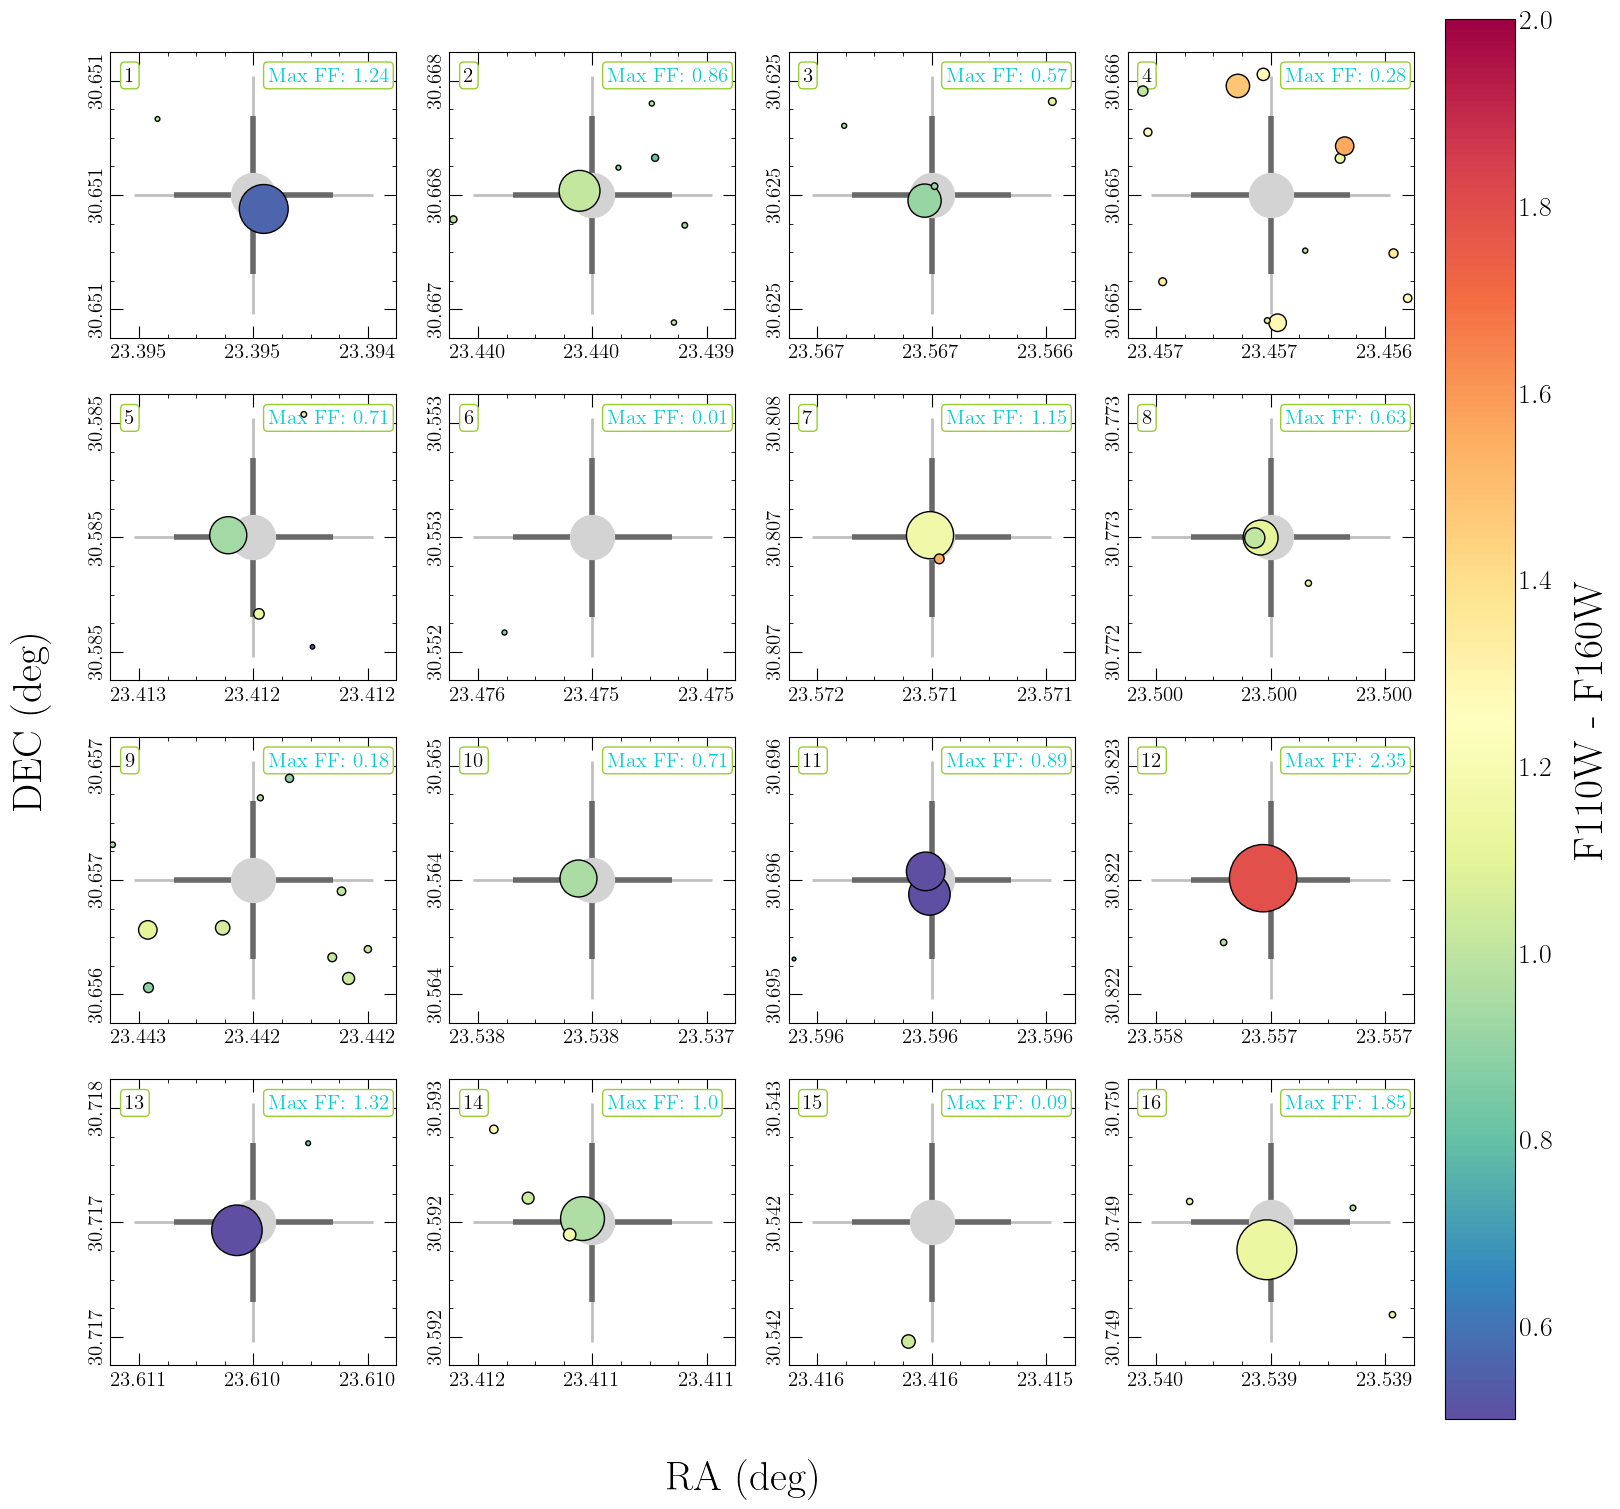

In [202]:
fig, axs = plt.subplots(int(n/4),4, figsize=(14,14*(n/16)))
fig.tight_layout(h_pad=0, w_pad=-1)


for i,ax in enumerate(axs.ravel()[:n]):
 ob, = np.where(spitzer['index'] == first_n[i])
 ph, = np.where(match_ids == first_n[i])
    
 matches_ff = flux_fracs[ph]
 colors_match = col[ph]
 cmh = cm.get_sub_cmap('Spectral_r', 0.0, 1.0)
 ordered = np.argsort(matches_ff)[::-1]
 max_ff = matches_ff[ordered][0].round(2)
    
 ax.set_aspect(1)   

 ax.errorbar(spitzer['ra'][ob], spitzer['dec'][ob], 
              xerr=(1.5/3600), yerr=(1.5/3600), 
            color='silver', 
            linewidth=2)
 ax.errorbar(spitzer['ra'][ob], spitzer['dec'][ob], 
              xerr=(1/3600), yerr=(1/3600), 
            color='dimgrey', 
            linewidth=4)

 wplot = ax.scatter(spitzer['ra'][ob], spitzer['dec'][ob], 
           s=1e3,
           c='lightgrey',
           label='Spitzer Source', 
           zorder=5)
 cplot = ax.scatter(RA[ph], 
                   DEC[ph], 
                     s=matches_ff*1e3, 
                     edgecolors='black', 
                     c=colors_match, 
                     cmap=cmh, 
                     vmin=0.5, vmax=2., 
                     label='HST Matches', 
                     zorder=7) 
 
 x,y = spitzer['ra'][int(ob)], spitzer['dec'][int(ob)]
 ax.set_xlim(x+0.0005, x-0.0005)
 ax.set_xticks([x-0.0004, x, x+0.0004])
 ax.set_xticklabels(["{:.3f}".format(x-0.0004),"{:.3f}".format(x),"{:.3f}".format(x+0.0004)], ha='center')
 ax.set_ylim(y-0.0005, y+0.0005)
 ax.set_yticks([y-0.0004, y, y+0.0004])
 ax.set_yticklabels(["{:.3f}".format(y-0.0004),"{:.3f}".format(y),"{:.3f}".format(y+0.0004)], va='center')
 ax.tick_params(axis='x',labelsize=15)
 ax.tick_params(axis='y',labelsize=15, rotation=90)


 maxf_text = ax.text(x-0.00005, y+0.0004, 'Max FF: ' + str(max_ff), 
         fontsize=15, fontweight='bold', 
         color='darkturquoise', 
         bbox=dict(boxstyle='round, pad=0.2', fc='white', ec='yellowgreen', lw=1))
 
 plotnum_text = ax.text(x+0.00045, y+0.0004, str(i+1),
                       fontsize=15, fontweight='bold',
                       bbox=dict(boxstyle='round, pad=0.2', fc='white', ec='yellowgreen'))
# end of loop

hst_cax = fig.add_axes([1.0, 0.0, 0.05, 1])
hst_cbar = fig.colorbar(cplot, cax=hst_cax)
hst_cbar.ax.tick_params(which='both', size=0)
hst_cbar.set_label('F110W - F160W')

fig.text(0.5, -0.05, 'RA (deg)', horizontalalignment='center', fontsize=30);
fig.text(-0.025, 0.5, 'DEC (deg)', rotation='vertical', verticalalignment='center', fontsize=30);

plt.savefig('./images/cutout_plots.png', bbox_inches='tight')

## Random Matches

In [230]:
shifts = np.array([-36, -24, -12, 12, 24, 36])
distances_shift = []
flux_fracs_shift = []
ras_shift = []
decs_shift = []
uw_ind = []
cols_shift = []

In [231]:
#this errorored the first time I ran it, solved by changing selction to IR_GST then back to COL_CUT
#not sure what the problem actually is, look into if happens again

fd_hst = phatter.FD_36.evaluate(selection='COL_CUT')

<string>:1: RuntimeWarning: overflow encountered in power
<string>:1: RuntimeWarning: overflow encountered in multiply


In [208]:
for j,shift in enumerate(shifts):
  ra_shift = spitzer['ra'] + (shift/3600)
  d = []
  f = []
  ra = []
  dec = []
  uind = []
  color=[]

  for i,source in enumerate(spitzer):                
    dd = np.sqrt( ((RA - ra_shift[i])*np.cos(spitzer['dec'][i] * np.pi / 180))**2 + 
               (DEC - spitzer['dec'][i])**2)
    fmatched, = np.where(dd <= 2/3600)
  
    if len(fmatched) != 0:
      total_flux = np.sum(fd_hst[fmatched])
      fff = fd_hst[fmatched] / spitzer['fd36'][i]

      d.append(dd[fmatched])
      f.append(fff)
      ra.append(RA[fmatched])
      dec.append(DEC[fmatched])
      uind.append([i]*len(fmatched))
      color.append(col[fmatched])
        

  dds = [x for group in d for x in group]
  ffs = [x for group in f for x in group]
  ras = [x for group in ra for x in group]
  decs = [x for group in dec for x in group]
  inds = [x for group in uind for x in group]
  cols = [x for group in color for x in group]

  distances_shift.append(dds)
  flux_fracs_shift.append(ffs)
  ras_shift.append(ras)
  decs_shift.append(decs)
  uw_ind.append(inds)
  cols_shift.append(cols)

In [207]:
for j,shift in enumerate(shifts):
  dec_shift = spitzer['dec'] + (shift/3600)
  d = []
  f = []
  ra = []
  dec = []
  uind = []
  color = []

  for i,source in enumerate(spitzer):                
    dd = np.sqrt( ((RA - spitzer['ra'][i])*np.cos(dec_shift[i] * np.pi / 180))**2 + 
               (DEC - dec_shift[i])**2)
    fmatched, = np.where(dd <= 2/3600)
  
    if len(fmatched) != 0:
      total_flux = np.sum(fd_hst[fmatched])
      fff = fd_hst / total_flux

      d.append(dd[fmatched])
      f.append(fff[fmatched])
      ra.append(RA[fmatched])
      dec.append(DEC[fmatched])
      uind.append([i]*len(fmatched))
      color.append(col[fmatched])
        

  dds = [x for group in d for x in group]
  ffs = [x for group in f for x in group]
  ras = [x for group in ra for x in group]
  decs = [x for group in dec for x in group]
  inds = [x for group in uind for x in group]
  cols = [x for group in color for x in group]

  distances_shift.append(dds)
  flux_fracs_shift.append(ffs)
  ras_shift.append(ras)
  decs_shift.append(decs)
  uw_ind.append(inds)
  cols_shift.append(cols)

In [209]:
d_shift = np.array([l for group in distances_shift for l in group])
f_shift = np.array([k for group in flux_fracs_shift for k in group])
c_shift = np.array([j for group in cols_shift for j in group])

In [210]:
false_ra = np.array([x for group in ras_shift for x in group])
false_dec = np.array([x for group in decs_shift for x in group])
false_uind = np.array([x for group in uw_ind for x in group])

In [211]:
rand_no_ones, = np.where(f_shift != 1.0)

In [212]:
# Set up KDE for observed and random match data
d_shift_frac = d_shift / (mean_sep/3600)

false_data = np.array([d_shift_frac[rand_no_ones], f_shift[rand_no_ones]])
false_kde = gaussian_kde(false_data)#, bw_method=0.2)

obs_data = np.array([df[no_ones], ff[no_ones]])
obs_kde = gaussian_kde(obs_data)

X,Y = np.meshgrid(np.linspace(0,1,200), np.linspace(0.025,0.2,200))
points = np.vstack([X.ravel(), Y.ravel()])

In [213]:
obs_df_data = {'dist_frac':df[no_ones],
               'flux_frac':ff[no_ones],
               '110_160_col':col[match][no_ones]
              }

rand_df_data = {'dist_frac':d_shift_frac[rand_no_ones],
               'flux_frac':f_shift[rand_no_ones],
               '110_160_col':c_shift[rand_no_ones]
              } 

In [214]:
obs = pd.DataFrame(obs_df_data)
rand = pd.DataFrame(rand_df_data)

In [215]:
#obs.to_csv('observed.csv')

In [216]:
#art.to_csv('artificial.csv')

In [217]:
false_z = false_kde(points)

In [218]:
obs_z = obs_kde(points)

In [219]:
false_Z = np.reshape(false_z, X.shape)
norm_false_Z = false_Z / np.sum(false_Z)
obs_Z = np.reshape(obs_z, X.shape)
norm_obs_Z = obs_Z / np.sum(obs_Z)

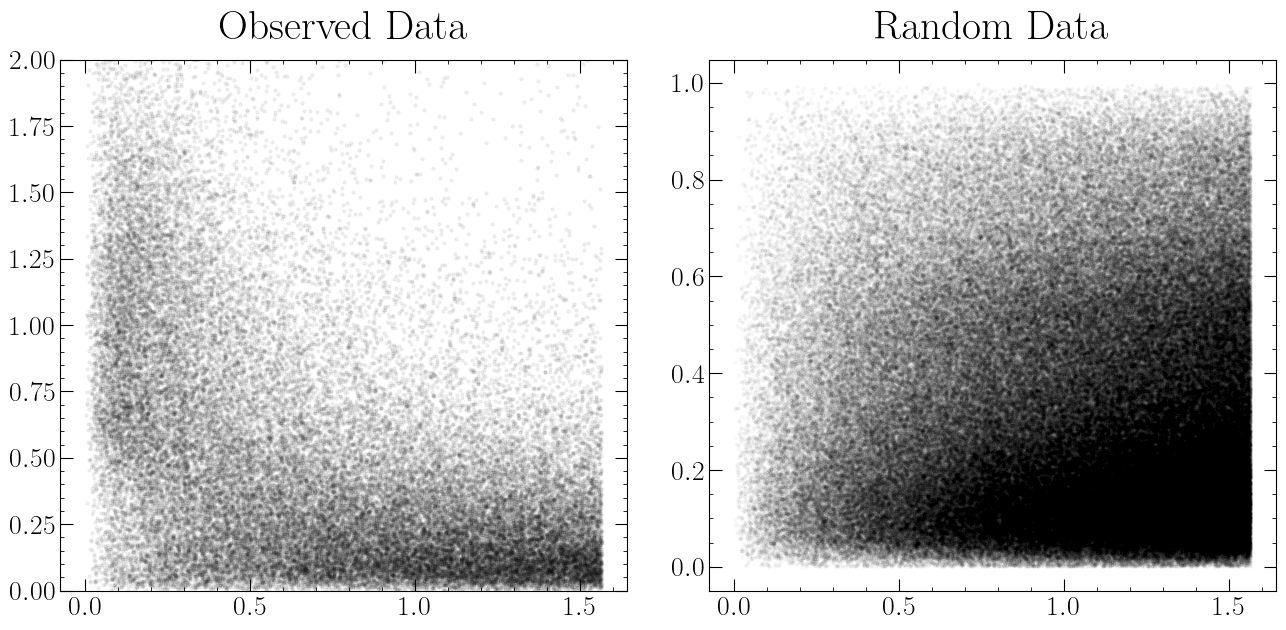

In [229]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(13,6)
fig.tight_layout(w_pad=2)

cmap_data = cm.get_sub_cmap('rainbow', 0.0, 1.0)
ss = np.argsort(c_matched[no_ones])#[::-1]
ffff = np.argsort(c_shift[rand_no_ones])
obs = ax[0].scatter(df[no_ones][ss], ff[no_ones][ss], 
                    s=5, alpha=0.05, 
                    c='black'#c_matched[ss], cmap=cmap_data,
                    #vmin=0.5, vmax=2.0
                    )
ax[0].set_ylim(0,2)
ax[0].set_title('Observed Data', fontsize=30);


false = ax[1].scatter(np.array(d_shift_frac[rand_no_ones])[ffff], np.array(f_shift[rand_no_ones])[ffff], 
                      s=5, alpha=0.02, 
                      c='black'
                      #c=np.array(c_shift[rand_no_ones])[ffff], cmap=cmap_data,
                      #vmin=0.5, vmax=2.0
                     )
ax[1].set_title('Random Data', fontsize=30);

#plt.savefig('./images/df_ff_comparison.eps', format='eps', bbox_inches='tight')

In [221]:
len(col[match]), len(ff)

(54430, 54430)

In [222]:
x = np.linspace(0,1,1000)
x = x[1:]

for val in x:
    obs_hist = np.histogram2d(df[no_ones], ff[no_ones], bins=bins)[0]
    art_hist = np.histogram2d(d_shift_frac[rand_no_ones], f_shift[rand_no_ones], bins=bins)[0]
    sub_hist = (obs_hist - val*art_hist) / np.sum(obs_hist - val*art_hist)
    check = np.sum(sub_hist, axis=1)
    if np.min(check) < 0.0:
        print(val.round(6))
        break
    else:
        pass

0.03003


In [223]:
#ah, xdgs, ydgs = np.histogram2d(d_shift_frac[keep_a], f_shift[keep_a], bins=100)
ah, xdgs, ydgs = np.histogram2d(d_shift_frac[rand_no_ones], f_shift[rand_no_ones], bins=100)
oh,_,_ = np.histogram2d(df[no_ones], ff[no_ones], bins=[xdgs, ydgs])

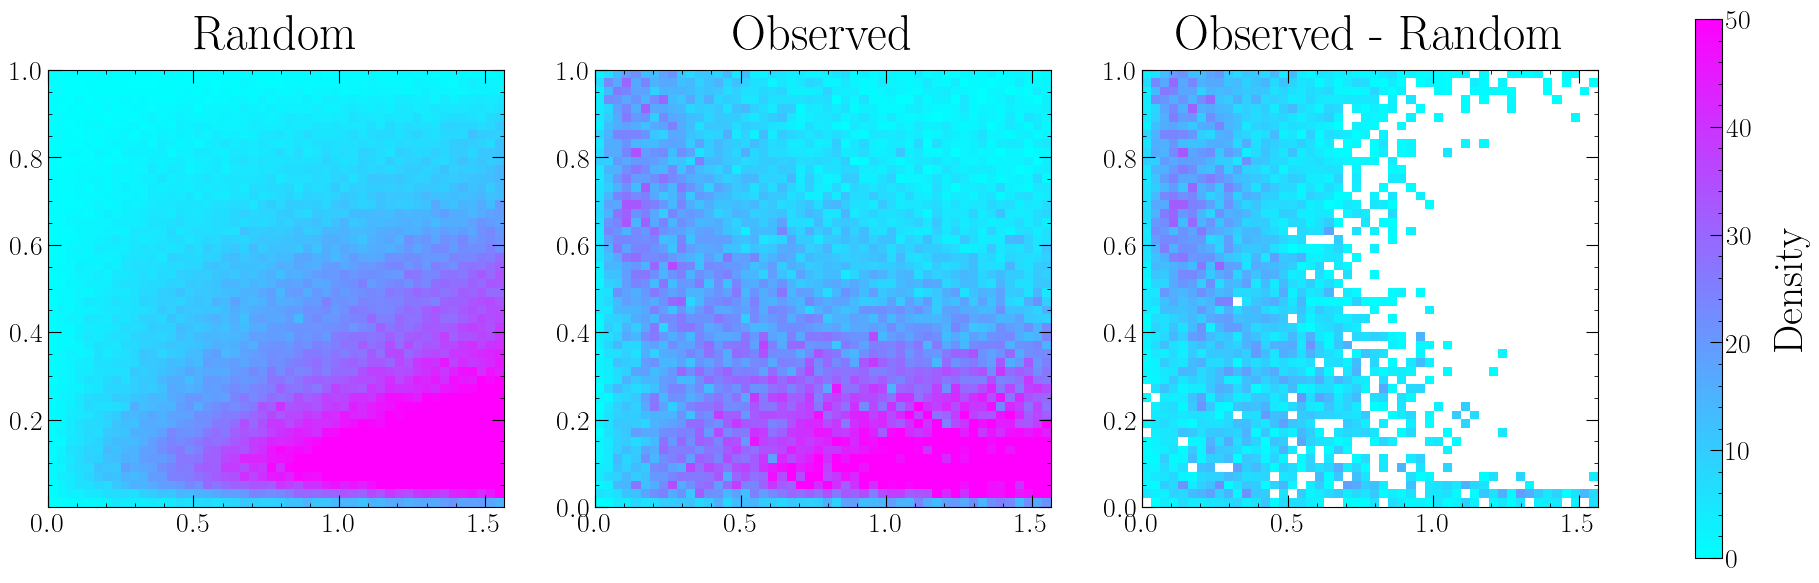

In [224]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_size_inches(25,7)

cmap = copy.copy(mpl.cm.get_cmap('cool'))
cmap.set_under('w')

ah,xdgs,ydgs = np.histogram2d(d_shift_frac[rand_no_ones].value, f_shift[rand_no_ones], 
                              bins=50
                              )

ax1.imshow(np.rot90(ah/12),
          extent=[0,np.max(d_shift_frac[rand_no_ones].value), 0.0, 1.0],
          vmin=0, vmax=50,
          cmap=cmap)


ax1.grid(visible=False, which='both', axis='both')
ax1.set_title('Random')
ax1.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])

oh,_,_ = np.histogram2d(df[no_ones].value, ff[no_ones], 
                            bins=[xdgs, ydgs] 
                           )
    
ax2.imshow(np.rot90(oh), 
          extent=[0,np.max(df[no_ones].value),0.0,1.0], 
           vmin=0, vmax=50,
           cmap=cmap
          )
                       

ax2.grid(visible=False, which='both', axis='both')
ax2.set_title('Observed')


cplot = ax3.imshow(np.rot90(oh - (ah/12)), 
                   extent=[0,np.max(d_shift_frac[rand_no_ones].value),0.0,1.0], 
                   vmin=0, vmax=50,
                  cmap=cmap)

ax3.grid(visible=False, which='both', axis='both');
ax3.set_title('Observed - Random');
fig.colorbar(cplot, ax=[ax1, ax2, ax3], location='right', label='Density');

ax1.set_aspect(1.5)
ax2.set_aspect(1.5)
ax3.set_aspect(1.5)

#plt.savefig('./images/ff_df_hists.eps', format='eps', bbox_inches='tight')

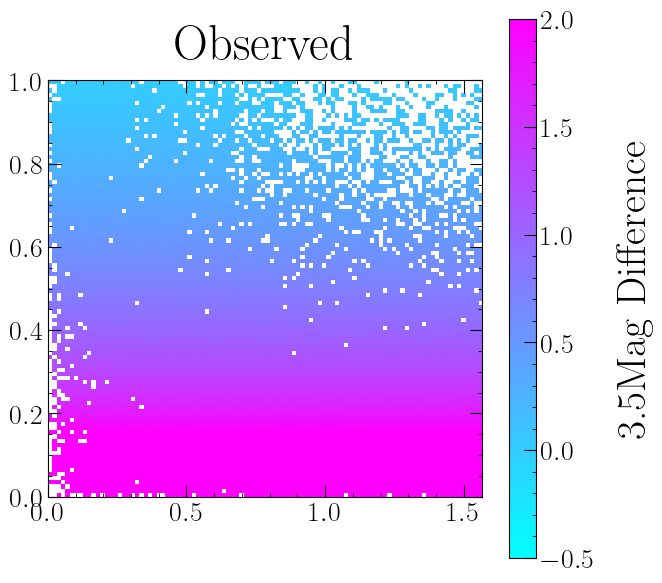

In [225]:
fig, ax2 = plt.subplots(1)
fig.set_size_inches(7,7)

cmap = copy.copy(mpl.cm.get_cmap('cool'))


ah,xdgs,ydgs,_ = stats.binned_statistic_2d(d_shift_frac[rand_no_ones].value, f_shift[rand_no_ones], 
                              values='none', statistic='count', bins=100
                              )


oh,_,_,_ = stats.binned_statistic_2d(df[no_ones].value, ff[no_ones], 
                            mag_difs[match][no_ones], statistic='mean', bins=[xdgs, ydgs] 
                           )
    
mplot = ax2.imshow(np.rot90(oh), 
          extent=[0,np.max(df[no_ones].value),0.0,1.0], 
           vmin=-0.5, vmax=2,
           cmap=cmap
          )
                       

ax2.grid(visible=False, which='both', axis='both')
ax2.set_title('Observed')

fig.colorbar(mplot, ax=ax2, location='right', label='3.5Mag Difference');

ax2.set_aspect(1.5)


In [226]:
col_bins = np.linspace(0.3, 3, 7)

kdes = []
X,Y = np.meshgrid(np.linspace(0,1,200), np.linspace(0.025,0.2,200))
points = np.vstack([X.ravel(), Y.ravel()])

for i in range(len(col_bins) - 1):
    try:
        sec, = np.where((c_matched > col_bins[i]) & (c_matched <= col_bins[i+1]))
        data = np.array([df[sec], ff[sec]])
        kde = gaussian_kde(data)
        smooth = kde(points)
        smooth_grid = np.reshape(smooth, X.shape)
        kdes.append(smooth_grid)
    except:
        print(i)

4
5


In [ ]:
1 / (np.max(ah/12) / np.max(oh))

In [ ]:
ah

In [ ]:
final_hist = oh - (ah/12)
final_hist = final_hist*10
final_hist = final_hist.round()
final_hist = final_hist.ravel()

In [ ]:
neg, = np.where(final_hist < 0)
final_hist[neg] = 0

In [ ]:
final_hist

In [ ]:
xpts, ypts = np.linspace(0, np.max(d_test), 50), np.linspace(0.1, 1.0)

In [ ]:
finalx = []
finaly = []
for i in range(50):
    for j in range(50):
        xpt = [xpts[i]]
        ypt = [ypts[j]]
        rpt = int(final_hist[50*i + j])
        finalx = finalx + xpt*rpt
        finaly = finaly + ypt*rpt

In [ ]:
zr, = np.where(final_hist == 0)
final_hist[zr] = -1

In [ ]:
f = (oh - ah/12)

In [ ]:
f

In [ ]:
fneg, = np.where(f < 0)
#f[fneg] = 0
fneg

In [ ]:
fig, ax = plt.subplots(1)

#plot = ax.hist2d(finalx, finaly, bins=50, cmap=cmap, vmin=0, vmax=50);

img = ax.imshow(np.rot90(oh - (ah/12)), extent=[0, np.max(d_test), 0.1, 1.0], 
          cmap=cmap, vmin=0, vmax=5)

plt.colorbar(plot[3], ax=ax)
ax.set_aspect(3.5);

In [ ]:
ocdat = col[match][not_ones][keep_o]
oconditions = [(ocdat < 0.75), ((ocdat >= 0.75) & (ocdat < 0.85)), ((ocdat >= 0.85) & (ocdat < 0.95)), ((ocdat >= 0.95) & (ocdat < 1.05)), ((ocdat>=1.05) & (ocdat<1.3)), (ocdat>=1.3)]
ochoices = ['$110-160 < 0.75$', '$0.75 <=110-160< 0.85$', '$0.85 <=110-160< 0.95$', '$0.95 <=110-160< 1.05$', '$1.0 <=110-160< 1.25$', '$1.25 <=110-160$']
order = [1, 2, 3, 4, 5, 6]

In [ ]:
#acdat = c_shift[keep_a]
acdat = c_test
acond = [(acdat < 0.75), ((acdat >= 0.75) & (acdat < 0.85)), ((acdat >= 0.85) & (acdat < 0.95)), ((acdat >= 0.95) & (acdat < 1.05)), ((acdat>=1.05) & (acdat<1.3)), (acdat>=1.3)]
achoic = ['$110-160 < 0.75$', '$0.75 <=110-160< 0.85$', '$0.85 <=110-160< 0.95$', '$0.95 <=110-160< 1.05$', '$1.0 <=110-160< 1.25$', '$1.25 <=110-160$']

In [ ]:
ohues = np.select(oconditions, ochoices)
o_ord = np.select(oconditions, order)
ahues = np.select(acond, achoic)
a_ord = np.select(acond, order)

In [ ]:
od = {'df':dd_obs[keep_o],
      'ff':ff_obs[keep_o],
      'col':ocdat,
      'hue':ohues,
      'order':o_ord
     }
odf = pd.DataFrame(od)

ad = {'df':d_shift_frac[keep_a],
      'ff':f_shift[keep_a],
      'col':acdat,
      'hue':ahues,
      'order':a_ord
      }
adf = pd.DataFrame(ad)

In [ ]:
ad = {'df':d_test,
      'ff':f_test,
      'col':acdat,
      'hue':ahues,
      'order':a_ord
      }
adf = pd.DataFrame(ad)

In [ ]:
odf.sort_values('order', inplace=True)
adf.sort_values('order', inplace=True)

In [ ]:
#mpl.rcParams['axes.prop_cycle'] = cycler(color=['lime', 'greenyellow', 'yellow', 'orange', 'deepskyblue', 'crimson'])
mpl.rcParams['axes.prop_cycle'] = cycler(color=['lemonchiffon', 'lemonchiffon', 'lemonchiffon', 'lemonchiffon', 'deepskyblue', 'crimson'])

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(25,12)


ax1.set_xlim(0,3.5)
ax1.set_ylim(0.2,1)

kde = sns.kdeplot(data=odf, ax=ax1, x='df', y='ff',
            levels=10,
            hue='hue', hue_order=['$0.75 <=110-160< 0.85$', '$0.85 <=110-160< 0.95$', '$0.95 <=110-160< 1.05$', '$1.0 <=110-160< 1.25$', '$110-160 < 0.75$', '$1.25 <=110-160$'],
            legend=False);

ax2.set_xlim(0,3.5)
ax2.set_ylim(0.2,1)
sns.kdeplot(data=odf, ax=ax2, x='df', y='ff',
            cmap='YlGnBu', cbar=False,
            fill=True, thresh=0.01, levels=20);

fig.text(0.5, 0.95, 'Observed', ha='center', fontsize=30);

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(25,12)


ax1.set_xlim(0,3.5)
ax1.set_ylim(0.2,1)
sns.kdeplot(data=adf, ax=ax1, x='df', y='ff',
            levels=20,
            hue='hue', hue_order=['$0.75 <=110-160< 0.85$', '$0.85 <=110-160< 0.95$', '$0.95 <=110-160< 1.05$', '$1.0 <=110-160< 1.25$', '$110-160 < 0.75$', '$1.25 <=110-160$'],
            legend=False);

ax2.set_xlim(0,3.5)
ax2.set_ylim(0.2,1)
sns.kdeplot(data=adf, ax=ax2, x='df', y='ff',
            cmap='YlGnBu', cbar=False,
            fill=True, thresh=0.01, levels=20);

fig.text(0.5, 0.95, 'Artificial', ha='center', fontsize=30);

In [ ]:
ob_plot = sns.jointplot(data=odf, x='df', y='ff', 
              #hue='hue', hue_order=['$0.75 <=110-160< 0.85$', '$0.85 <=110-160< 0.95$', '$0.95 <=110-160< 1.05$', '$1.0 <=110-160< 1.25$', '$110-160 < 0.75$', '$1.25 <=110-160$'],
              kind='kde',# bins=100,
              height=10, ratio=4,
              xlim=(0,3.5), ylim=(0.2,1),
              legend=False, 
              fill=True,
              marginal_kws=dict(color='blue')
             );

In [ ]:
art_plot = sns.jointplot(data=adf, x='df', y='ff', 
              #hue='hue', hue_order=['$0.75 <=110-160< 0.85$', '$0.85 <=110-160< 0.95$', '$0.95 <=110-160< 1.05$', '$1.0 <=110-160< 1.25$', '$110-160 < 0.75$', '$1.25 <=110-160$'],
              kind='kde',# bins=100,
              height=10, ratio=4,
              xlim=(0,3.5), ylim=(0.2,1),
              legend=False, 
              fill=True,
              marginal_kws=dict(color='blue')
             );

In [ ]:
fig = plt.figure(figsize=(20,6))

x = 1.0

kde_plots = [norm_false_Z, norm_obs_Z, (norm_obs_Z - x*norm_false_Z)]
dedges = np.histogram(dd_obs, bins=bins, density=True)[1]
fedges = np.histogram(ff_obs, bins=bins, density=True)[1]

dhists = [d_shift_frac, dd_obs, np.sum(sub_hist, axis=1)]
fhists = [f_shift, ff_obs, np.sum(sub_hist, axis=0)]
titles = ['Artificial', 'Observed', 'Observed - ' + str(x) + 'xArtificial']
left = [0.0, 0.33, 0.66]

cmap_kde = cm.get_sub_cmap('viridis', 0.0, 1.0)
norm = mpl.colors.LogNorm(vmin=1e-5, vmax=1e-4)

cmaps = []

for i in range(3):
    ax = fig.add_axes([left[i], 0.0, 0.3, 0.8])
    ax.set_aspect(3.5)
    smooth = ax.imshow(np.flipud(kde_plots[i]),
                      cmap=cmap_kde,
                            extent=[0,1,0,1], norm=norm)
    cmaps.append(smooth)
    
    hax1 = fig.add_axes([left[i] + 0.03, 0.81, 0.239, 0.16], sharex=ax)
    hax2 = fig.add_axes([left[i] + 0.274, 0.0, 0.05, 0.8], sharey=ax)
    hax1.tick_params(which='both', labelcolor='none')
    hax2.tick_params(which='both', labelcolor='none')
    hax1.set_title(titles[i], fontsize=20)
    
    
    
    if (i != 2):
        hax1.hist(dhists[i], bins=bins, density=True, color='limegreen')
        hax2.hist(fhists[i], orientation='horizontal', bins=bins, density=True, color='limegreen')
    else:
        hax1.bar(x=dedges[:-1], height=dhists[i], width=0.01, align='edge', color='limegreen')
        hax2.barh(y=fedges[:-1], width=fhists[i], height=0.01, align='edge', color='limegreen')
        
cax = fig.add_axes([1.01, 0.0, 0.025, 0.8])

plt.colorbar(cmaps[2], cax=cax);

fig.text(-0.025, 0.5, 'Fractional Flux', rotation='vertical', verticalalignment='center', fontsize=25);
fig.text(0.5, -0.15, 'Fractional Distance', horizontalalignment='center', fontsize=25);

plt.savefig('./images/kde_combo.png', bbox_inches='tight')

## Catalog

In [ ]:
###Create table with index of the PHATTER data and the objid of the wise source it matched to

#objid_key = Table([phatter.INDEX.evaluate(), match_ids], names=['phatter_index', 'unwise_objid'])

In [ ]:
#m, = np.where(objid_key['unwise_objid'] != '****************')

In [ ]:
#objid_key[m].write('objid_key.csv')
